# **Mount to google drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Import needed libraries**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from random import randrange
from matplotlib.pyplot import figure
import time
import random
import matplotlib as plt
from random import seed
from random import random
from csv import reader
from math import exp
import sys
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
from google.colab import files

# All needed *functions* 

In [0]:
def formonehot(data,i):
    data = np.array(data)
    onehot = np.array(data/i)
    onehot[onehot != 1] = 0
    return onehot

def crossentropyloss(predicted,label):
    sum = 0
    for i in range(len(predicted)):
        labels = onehotlabel(label)
        sum += -1*np.sum(labels*np.log(np.amax(predicted[i])))
    return sum/372500

def onehotlabel(label):
    onehot = np.zeros(250)
    onehot[label] = 1
    return onehot

def softmax(predicteds):
    softmaxs = np.exp(predicteds - np.max(predicteds))/np.sum(np.exp(predicteds - np.max(predicteds)))
    return softmaxs
        
def cost(error,outsForKL,rho,beta,wsums,lamda):
    mse = 0
    err= 0
    error = error.T
    ww = 0
    mse = np.sum(np.array([np.sum(np.array([column*column for column in errorofiteration]) for errorofiteration in error)]))

    mse = mse/((outsForKL[0]).shape[0])/2
    KL = 0
    KL = np.sum(np.array([calculateKL(outsForKL[out],rho) for out in range(outsForKL.shape[0])]))/(16*16)

    wsum = np.sum(wsums)


    loss = mse+lamda/2*wsum+beta* KL
    print(mse)
    print(wsum*lamda/2)
    print(beta*KL)
    return loss

def classError(o,lbls):
    acc = accuracy(o,lbls)
    return acc
def converttoGreyscale(data):
    rgbdata = np.transpose(data, (0,2,3,1))
    return np.dot(rgbdata[...,:3], [0.2126, 0.7152, 0.0722])
def removeMean(data):
    mean = data.reshape((data.shape[0],data.shape[1]*data.shape[2]))
    for i in range(data.shape[0]):
        mean[i] = mean[i] - np.mean(mean[i])
    return mean.reshape((mean.shape[0], int(np.sqrt(mean.shape[1])), int(np.sqrt(mean.shape[1]))))
def normalizegreyscales(data):
    sdeviation = np.std(data)
    normalized = data
    normalized[normalized >= sdeviation * 3] = sdeviation * 3
    normalized[normalized <= -sdeviation * 3] = -sdeviation * 3
    return normalized

def maping(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom

def preprocessdata(data):
    greyscales = converttoGreyscale(data)
    greyscales = removeMean(greyscales)
    normals = normalizegreyscales(greyscales)
    preprocesseddata = maping(normals, 0.1, 0.9)
    return preprocesseddata

def accuracy(o,lbls):
    count = 0
    predict = np.argmax(o,axis=1)
    for i in range(lbls.shape[0]):
        if predict[i]==lbls[i]:
            count = count+ 1
    return count/lbls.shape[0]*100

def organizeInput(image):
    x = np.ones(32*32)
    index = 0
    for row in image:
        for column in row:
            x[index]=((column))
            index = index + 1
    return x

def activation(inn,deriv =False):
    inn = np.tanh(inn)
    if deriv == True:
        return 1-inn*inn
    return inn
    # inn[inn<0]=0
    # if deriv==True:
    #     inn[inn>0]=1
    #     return inn
    # return inn

# Rescale dataset columns to the range 0-1
def normalize_dataset(arr):
    arr = arr - np.amin(arr,axis=0)
    arr = arr / np.amax(arr,axis = 0)
    return arr

# Find the min and max values for each column
def organizeData(dataPath):
    data = h5py.File(dataPath,'r+')
    trainims =(data['trainims'])
    trainlbls =(data['trainlbls'])
    testims=(data['testims'])
    testlbls =(data['testlbls'])
    return trainims,trainlbls,testims,testlbls

def organizeData2(dataPath):
    data = h5py.File(dataPath,'r+')
    trainx =np.array((data['trainx']))
    traind =np.array((data['traind']))
    valx=(data['valx'])
    vald =(data['vald'])
    testx=(data['testx'])
    testd =(data['testd'])
    words = data['words']
    return trainx,traind,valx,vald,testx,testd,words
  
def addBiasToDataset(dataset):
    size = dataset.shape[0]
    biasInDataset = -1*np.ones(size)
    return np.hstack((dataset,(biasInDataset.reshape(-1,1))))

def addbiasToInputs(layerInput):
    return np.hstack((layerInput,[-1]))

def forwardpropagate(W1,W2,testdata):
    outputs = list()
    outputs = [activation(np.dot(W2,activation(addbiasToInputs(np.dot(W1,img))))) for img in testdata]
    # for img in testdata:
    #     output = activation(np.dot(W2,activation(addbiasToInputs(np.dot(W1,img)))))
    #     outputs.append(output)
    return np.array(outputs)

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def shuffle(data,lbls):
    deck = ((np.hstack((data,lbls.reshape(1,-1).T))))
    deck = np.array(sorted(deck, key=lambda k: random.random()))
    data = deck.T[:-1].T
    lbls = deck.T[-1]
    return data,lbls

def shuffleauto(greyscale):
    deck = greyscale[:-1]
    deck = np.array(sorted(deck, key=lambda k: random.random()))
    # print(deck.shape)
    # print(greyscale[-1].reshape(1,-1).shape)
    # deck = np.append(deck,greyscale[-1].reshape(-1,1))
    deck = np.vstack((deck, greyscale[-1].reshape(1,-1)))
    return deck

def shuffle3(data,lbls):
    deck = ((np.hstack((data,lbls.reshape(1,-1).T))))
    deck = np.array(sorted(deck, key=lambda k: random.random()))
    data = deck.T[:-1].T
    lbls = deck.T[-1]
    return data,lbls

def formdata():
    Q2data =("/content/assign2_data1.h5")
    trainims,trainlbls,testims,testlbls = organizeData(Q2data)
    traindata = list()
    testdata = list()

    for image in trainims:
        inputs = organizeInput(image)
        traindata.append(inputs)

    for image in testims:
        inputs = organizeInput(image)
        testdata.append(inputs)

    traindata = np.array(traindata,dtype = float)
    trainlbls = np.array(trainlbls,dtype = float)
    testdata = np.array(testdata,dtype = float)
    testlbls = np.array(testlbls,dtype = float)

    traindata = (normalize_dataset(traindata))
    testdata = (normalize_dataset(testdata))
    traindata = addBiasToDataset(traindata)
    testdata = addBiasToDataset(testdata)
    return traindata,trainlbls,testdata,testlbls

    rhohats = np.array([(out) for out in outs if out>0])

def calculateKL(outs,rho):
    rhohats = np.array([(out) for out in outs if out>0])
    KL = np.sum(np.array([-1*rho*np.log(rhohat/rho) + (1-rho)*np.log((1-rho)/(1-rhohat)) for rhohat in rhohats]))
    return KL/outs.shape[0]

def loss(W,What,outs,e,learningrate,lamda,beta,rho):
    first = np.sum(e**2)/2
    second = lamda*(sum(sum(W.T[:-1]**2)))
    third = beta*calculateKL(outs,rho)
    return (first+second+third)


def removeintensitydata(clr):
    clr=[removeintensityimg(img) for img in clr]
    return clr
def removeintensityimg(imagee):  
    imagee = imagee.flatten()-np.mean(imagee.flatten())
    imagee =np.clip(imagee, -3*np.std(imagee), 3*np.std(imagee))
    # imagee =np.interp(imagee, (imagee.min(), imagee.max()), (0.1, 0.9))
    imagee = imagee.reshape(16,16)
    return imagee
def normalizeInputs(array):
    array = array - np.amin(array,axis = 0)
    array = array/np.amax(array,axis = 0)
    return array
def organizeData(dataPath):
    folder = h5py.File(dataPath,'r+')
    data =(folder['data'])
    invXForm =(folder['invXForm'])
    xForm=(folder['xForm'])
    return data,invXForm,xForm

def grayscale(R,G,B):
    # R = R-
    Y = 0.2126 * R + 0.7152 * G + 0.0722 * B
    return Y

def grayscale2(Rcon,Gcon,Bcon):
    Y = 0.2126 * Rcon + 0.7152 * Gcon + 0.0722 * Bcon
    return np.moveaxis(np.array(np.split(Y,16,axis=0)),0,1)

def cost(N,d,o,W1,W2,gamma,beta,p,phat):
    first = np.array((1/N)*sum(np.square(np.abs(d-o))))
    second = np.array((1/gamma)*(sum(W1)+sum(W2)))
    third = beta
    return first+second+third

def organizeInputs(greyscales):
    inputs = list()
    for row in range(len(greyscales)):
        inputs.append(np.matrix.flatten(greyscales[row]))
    return inputs

def preProcessing():
    global data
    global invXForm
    global xForm
    global inputs
    global greyscale
    data,invXForm,xForm = organizeData('/content/drive/My Drive/3/assign3_data1.h5')

    print("data")
    print(data)
    print("\ninvXForm")
    print(invXForm)
    print("\nxForm")
    print(xForm)

    data = np.array((data))
    print("-------------")
    rgb = np.moveaxis(data,1,3)
    print(rgb.shape)
    print("-------------")

    rows, cols = 10, 20
    fig, ax = plt.subplots(rows, cols,
                        sharex='col', 
                        sharey='row',
                        figsize =(18,16),
                        dpi = 80,
                        facecolor = 'w',
                        edgecolor = 'k')
    
    n = [randrange(10240) for i in range(200)]
    [[ax[row, col].imshow(np.array(rgb[n[row*20+col]])) for col in range(20)] for row in range(10)] 
    plt.show()

    Rcon = np.vstack((np.moveaxis(data, 0, 1)[0]))
    Gcon = np.vstack((np.moveaxis(data, 0, 1)[1]))
    Bcon = np.vstack((np.moveaxis(data, 0, 1)[2]))

    greyscales = grayscale2(Rcon,Gcon,Bcon)
    greyscales = removeintensitydata(greyscales)
    greyscales = np.array(greyscales,dtype = float)
    print(greyscales.shape)
    greyscales = preprocessdata(data)
    print(greyscales.shape)
    rows, cols = 10, 20
    fig, ax = plt.subplots(rows, cols,
                        sharex='col', 
                        sharey='row',
                        figsize =(18,16),
                        dpi = 80,
                        facecolor = 'w',
                        edgecolor = 'k')
    [[ax[row, col].imshow(np.array(greyscales[n[row*20+col]]),cmap='gray') for col in range(20)] for row in range(10)] 

    plt.show()
    greyscale = np.vstack((greyscales.T)).T
    print("preprocessing comlplete")
    print(time.ctime())

def aeCost(W,learningrate,rho,beta,lamda,QualityCheck = False):
    print(W.shape)
    # Wh = W1.T[:-1].T
    # W = Wh
    What = W.T
    trainlbls = traindata = greyscale
    losslist = list()
    # -------------------------------------------------------------------------------------------
    n = [randrange(10240) for i in range(100)]
    outs = list()
    reals = list()
    lamda = lamda/10000000
    trainshape = traindata.shape[0]
    for iterateno in range(traindata.shape[0]):
        W = What.T
        i = iterateno
        img = traindata[i]
        d = trainlbls[i]
        lbl = trainlbls[i]

        vhat = np.dot(What,img)
        y = activation(vhat).T
        v = np.dot(W,y)
        o = activation(v)

        e = (d-o)/trainshape*256
        if not(QualityCheck):
            lossforiteration = loss(W,W.T,o,e,learningrate,lamda,beta,rho)
            losslist.append(lossforiteration)
        elif 100<iterateno and iterateno<=200:
            outs.append(o.reshape(16,16))
            reals.append(lbl.reshape(16,16))
    if QualityCheck:
        reals = np.array(reals)
        outs = np.array(outs)
        # print(np.array(outs).shape)
        print("real")
        rows, cols = 10, 10
        fig, ax = plt.subplots(rows, cols,
                            sharex='col', 
                            sharey='row',
                            figsize =(18,16),
                            dpi = 80,
                            facecolor = 'w',
                            edgecolor = 'k')
        
        [[ax[row, col].imshow(np.array(reals[row*10+col]).T,cmap = 'gray') for col in range(10)] for row in range(10)] 
        plt.show()
        print("outputs")
        rows, cols = 10, 10
        fig, ax = plt.subplots(rows, cols,
                            sharex='col', 
                            sharey='row',
                            figsize =(18,16),
                            dpi = 80,
                            facecolor = 'w',
                            edgecolor = 'k')

        [[ax[row, col].imshow(np.array(outs[row*10+col]).T,cmap = 'gray') for col in range(10)] for row in range(10)] 
        plt.show()
        # diff = reals-outs
        # print("diff")
        # rows, cols = 10, 10
        # fig, ax = plt.subplots(rows, cols,
        #                     sharex='col', 
        #                     sharey='row',
        #                     figsize =(18,16),
        #                     dpi = 80,
        #                     facecolor = 'w',
        #                     edgecolor = 'k')

        # [[ax[row, col].imshow(np.array(diff[row*10+col]).T,cmap = 'gray') for col in range(10)] for row in range(10)] 
        # plt.show()
        # print("weights")
        # rows, cols = 10, 10
        # fig, ax = plt.subplots(rows, cols,
        #                     sharex='col', 
        #                     sharey='row')

        # [[ax[row, col].imshow(np.array(W1.T[:-1].T[row*10+col]).reshape(int(np.sqrt(W.shape[1])),int(np.sqrt(W.shape[1]-1))).T) for col in range(10)] for row in range(10)] 
        # plt.show()
    if not(QualityCheck):
        return sum(np.array(losslist)/trainshape)

def drawWeights(Weights):
    W = Weights.T
    print("weights")
    print(W.shape)
    imageshape = W.shape[0]
    imageaxisshape = int(np.sqrt(imageshape))
    
    rows, cols = imageaxisshape,imageaxisshape
    fig, ax = plt.subplots(rows, cols,
                        sharex='col', 
                        sharey='row',
                        figsize =(18,16),
                        dpi = 80,
                        facecolor = 'w',
                        edgecolor = 'k')
    [[ax[row, col].imshow(np.array(W[row*imageaxisshape+col]).reshape(16,16),cmap='gray') for col in range(imageaxisshape)] for row in range(imageaxisshape)] 
    plt.show()

# **The gradient descent solver**

In [0]:
def nn(hiddenNo,epochno,miniBatchno,learningrate,rho,beta,lamda,Loss=False):
    print("Hidden layer number:"+str(hiddenNo)+" Learning rate:"+str(learningrate)+" Epoch number:"+str(epochno)+" Batch size:"+str(miniBatchno))
    global W
    global What
    traindata = greyscale
    trainlbls = greyscale

    What= np.random.normal(0, 0.01,(hiddenNo,16*16))
    bhat = np.random.normal(0, 0.01,(hiddenNo)).reshape(-1,1)
    What =np.hstack((What, bhat))

    W = What.T[:-1]

    b = np.random.normal(0, 0.01,(16*16)).reshape(-1,1)
    W =np.hstack((W, b)).T
    lamda = lamda/10000000
    losslist = list()

    # Start training process
    for epoch in range(epochno):
        errorsForEpochs = list()
        # traindata = shuffleauto(greyscale)

        # display epoch index and current time
        if epoch==0:
            print("\n\nTraining started.   Time: "+time.ctime())
        
        title = ("\n"+"Epoch no: "+str(epoch)+" in "+str(epochno))
        sys.stdout.write(title +" Time: " +time.ctime())
        sys.stdout.flush()
        time.sleep(1)
        trainshape = traindata.shape[0]
        for iterateno in range(traindata.shape[0]):
            W = What.T[:-1]

            b = np.random.normal(0, 0.01,(256)).reshape(-1,1)
            W =np.hstack((W, b))
            # forward propagate
            # handling array constructions
            i = iterateno
            img = np.append(traindata[i],[-1])
            d = trainlbls[i]
            lbl = trainlbls[i]
            # activate hidden layer
            # vhat = list(np.dot(What,img))
            # vhat.append(-1)
            vhat = np.dot(What,img)
            vhat = np.append(vhat,[-1])
            # vhat = np.array(vhat,dtype = float)
            y = activation(vhat).T
            # activate output layer
            v = np.dot(W,y)
            o = activation(v)


            e = (d-o)/trainshape*16*16
            # if iterateno +1 ==trainshape and Loss:
            #     imagereal = img[:-1].reshape(16,16).T
            #     imageout = o.reshape(16,16).T
            #     plt.imshow(imagereal,cmap='gray')
            #     plt.show()
            #     plt.imshow(imageout,cmap='gray')
            #     plt.show()
            # store the error
            errorsForEpochs.append(e)
            # back propagate
            # back propagate the output layer

            o = np.array([index if index!=0 else zero for index in o])
            KLd = beta*(np.array([-1*rho/i/256+(1-rho)/(1-i/256) if i!=0 else 0 for i in o]))
            Tprime = activation(v,deriv = True)*np.identity(256,dtype=float)
            gradient = normalize(np.dot(Tprime,e+KLd+lamda*np.sum(What,axis = 0)[:-1]))/(256)

            KLdhat = beta*(np.array([-1*rho/i/hiddenNo+(1-rho)/(1-i/hiddenNo) if i!=0 else 0 for i in gradient]))
            Tprimehat = activation(vhat,deriv = True)*np.identity(hiddenNo+1,dtype = float)
            gradienthat = normalize(np.dot((np.dot(Tprimehat,W.T)),gradient+KLdhat+lamda*np.sum(W,axis = 1)))/(256)

            if iterateno%miniBatchno== 0:
                if not(iterateno==0 and epoch==0):#The first iteration of the first epoch does not take any update
                    W +=learningrate*(Wupdate)
                    What+=learningrate*(Whatupdate)
                    if Loss:
                        lossforiteration = loss(W,W.T,o,e,learningrate,lamda,beta,rho)
                        losslist.append(lossforiteration)
                Wupdate = (np.dot(gradient.reshape(-1,1),y.reshape(1,-1)))
                Whatupdate = (np.dot(gradienthat.reshape(-1,1),img.reshape(-1,1).T)[:-1])
            else:
                Wupdate += (np.dot(gradient.reshape(-1,1),y.reshape(1,-1)))
                Whatupdate += (np.dot(gradienthat.reshape(-1,1),img.reshape(-1,1).T)[:-1])

        if Loss:
            print(time.ctime())
            # print(mse)
            plt.plot(np.array(losslist))
            plt.show()
            print("Least cost occurs at iteration:")
            print(np.argmin(np.array(losslist))*miniBatchno)
            print("Least cost occurs at epoch: ")
            print(np.argmin(np.array(losslist))/trainshape*miniBatchno)
            print("min loss:")
            print(np.amin(np.array(losslist)))
    return W

# **Normalize data(preprocessing phase)**

data
<HDF5 dataset "data": shape (10240, 3, 16, 16), type "<f4">

invXForm
<HDF5 dataset "invXForm": shape (105, 768), type "<f8">

xForm
<HDF5 dataset "xForm": shape (768, 105), type "<f8">
-------------
(10240, 16, 16, 3)
-------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

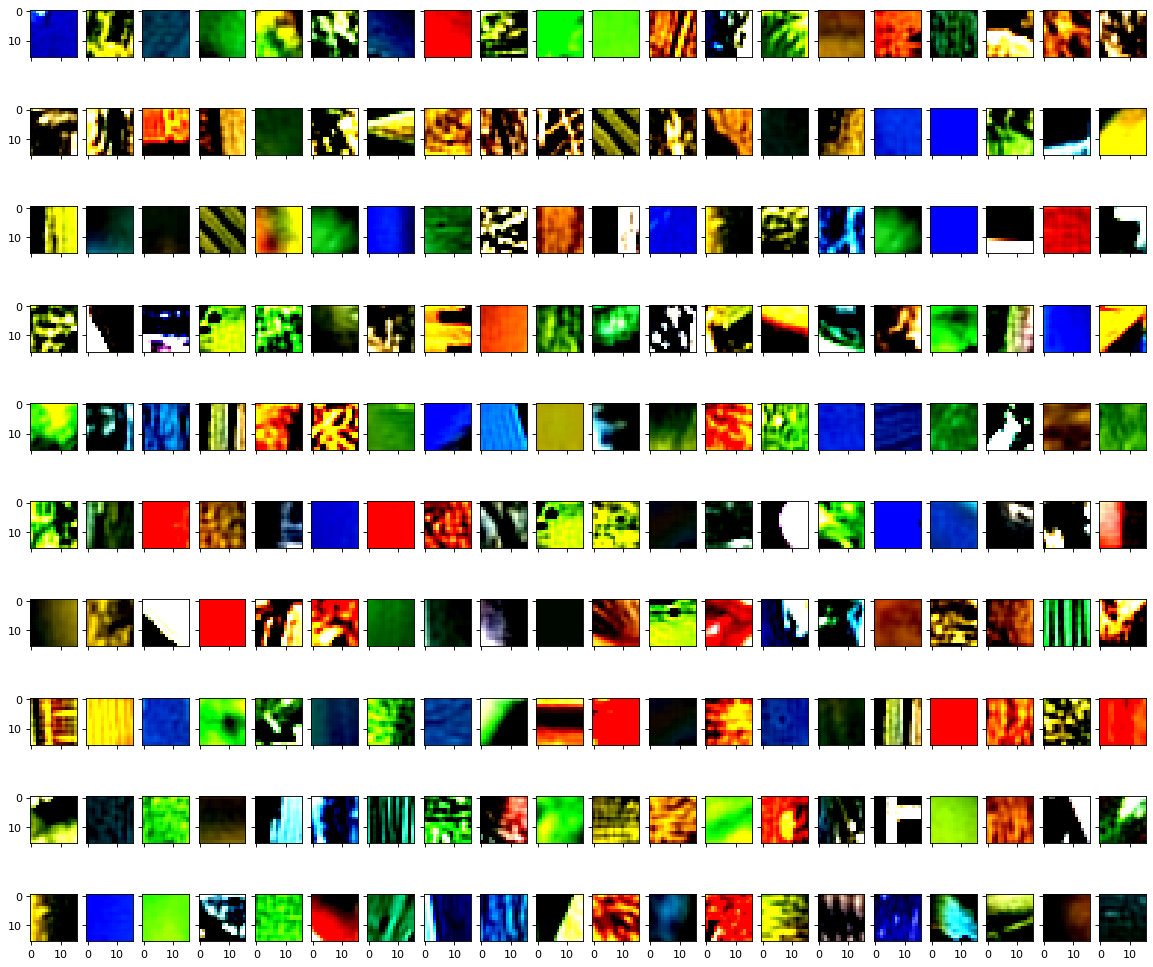

(10240, 16, 16)
(10240, 16, 16)


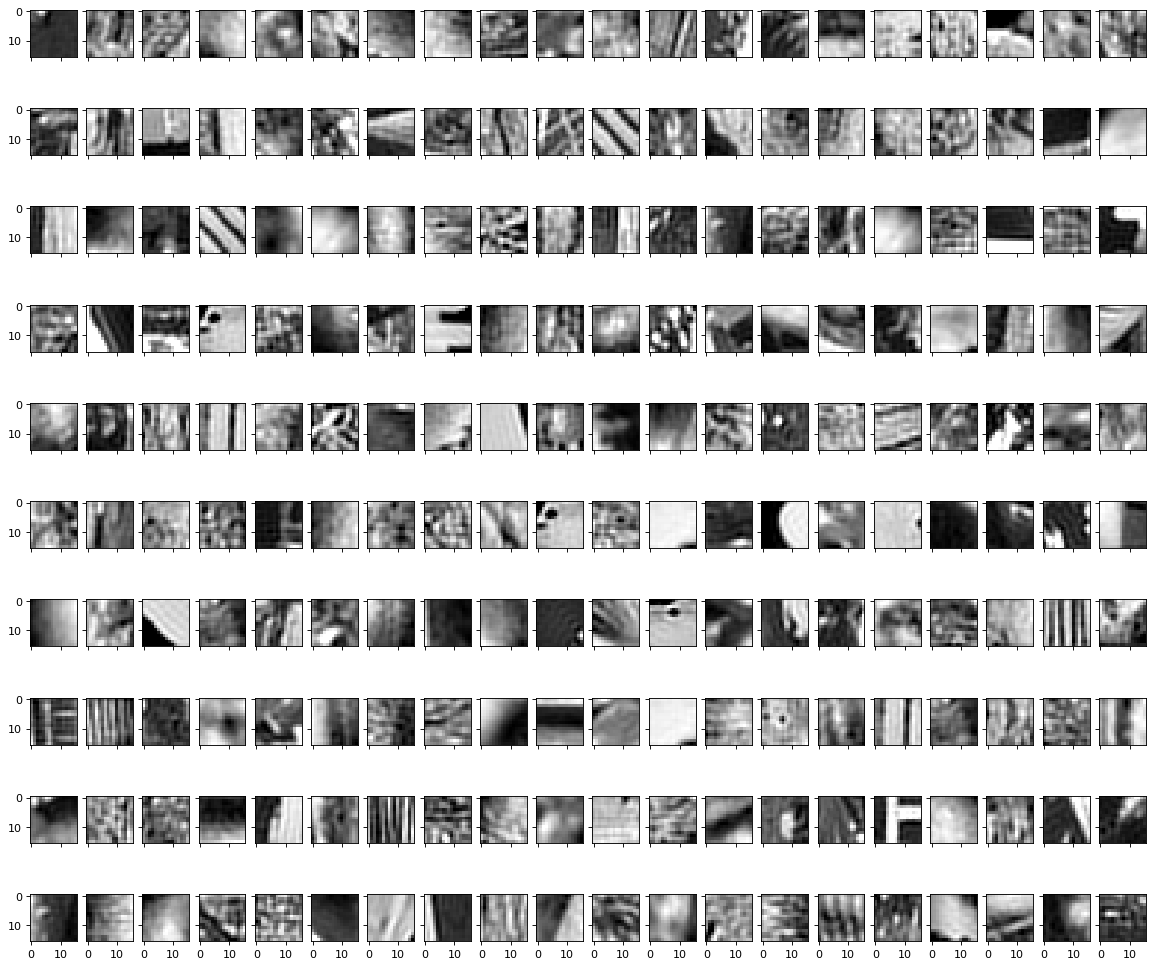

preprocessing comlplete
Sun Dec 15 18:42:13 2019


In [0]:
preProcessing()
greyscale  = (greyscale.reshape(10240,256))

# **Checking loss of iterations**

Hidden layer number:81 Learning rate:0.3 Epoch number:20 Batch size:1


Training started.   Time: Sun Dec 15 02:58:50 2019

Epoch no: 0 in 20 Time: Sun Dec 15 02:58:50 2019Sun Dec 15 02:59:37 2019


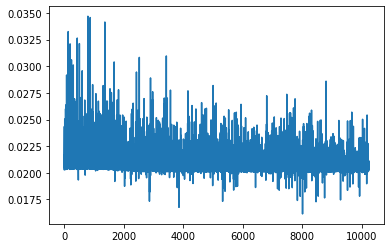

Least cost occurs at iteration:
8014
Least cost occurs at epoch: 
0.7826171875
min loss:
0.016134817020685432

Epoch no: 1 in 20 Time: Sun Dec 15 02:59:37 2019Sun Dec 15 03:00:24 2019


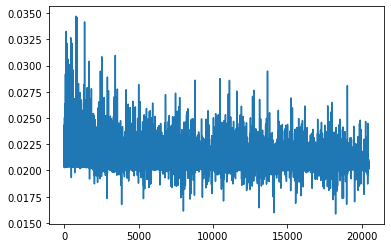

Least cost occurs at iteration:
18254
Least cost occurs at epoch: 
1.7826171875
min loss:
0.015859876867728294

Epoch no: 2 in 20 Time: Sun Dec 15 03:00:24 2019Sun Dec 15 03:01:12 2019


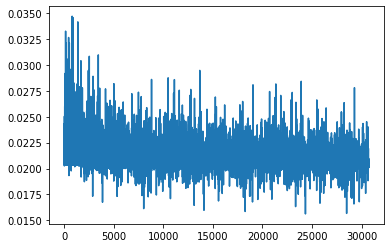

Least cost occurs at iteration:
24338
Least cost occurs at epoch: 
2.3767578125
min loss:
0.015624713129405905

Epoch no: 3 in 20 Time: Sun Dec 15 03:01:12 2019Sun Dec 15 03:01:59 2019


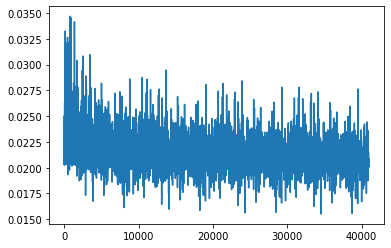

Least cost occurs at iteration:
34578
Least cost occurs at epoch: 
3.3767578125
min loss:
0.01551745719088299

Epoch no: 4 in 20 Time: Sun Dec 15 03:02:00 2019Sun Dec 15 03:02:47 2019


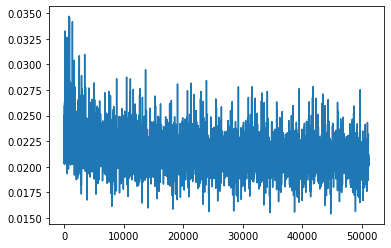

Least cost occurs at iteration:
44818
Least cost occurs at epoch: 
4.3767578125
min loss:
0.015392256171475476

Epoch no: 5 in 20 Time: Sun Dec 15 03:02:47 2019Sun Dec 15 03:03:34 2019


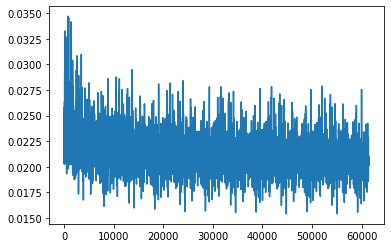

Least cost occurs at iteration:
44818
Least cost occurs at epoch: 
4.3767578125
min loss:
0.015392256171475476

Epoch no: 6 in 20 Time: Sun Dec 15 03:03:35 2019Sun Dec 15 03:04:22 2019


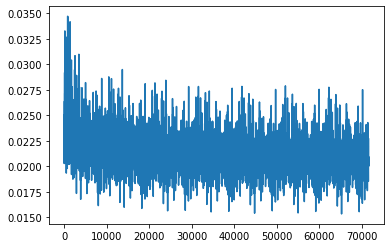

Least cost occurs at iteration:
65298
Least cost occurs at epoch: 
6.3767578125
min loss:
0.015320222857266686

Epoch no: 7 in 20 Time: Sun Dec 15 03:04:22 2019Sun Dec 15 03:05:09 2019


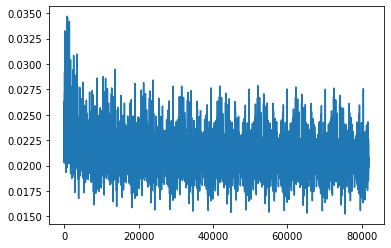

Least cost occurs at iteration:
75538
Least cost occurs at epoch: 
7.3767578125
min loss:
0.015237163999449552

Epoch no: 8 in 20 Time: Sun Dec 15 03:05:09 2019Sun Dec 15 03:05:55 2019


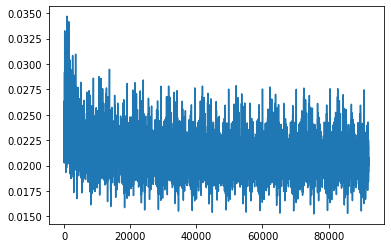

Least cost occurs at iteration:
75538
Least cost occurs at epoch: 
7.3767578125
min loss:
0.015237163999449552

Epoch no: 9 in 20 Time: Sun Dec 15 03:05:55 2019Sun Dec 15 03:06:41 2019


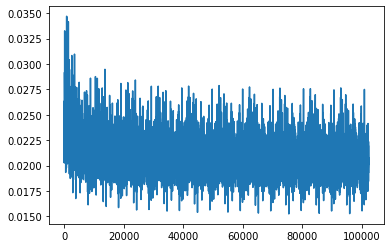

Least cost occurs at iteration:
75538
Least cost occurs at epoch: 
7.3767578125
min loss:
0.015237163999449552

Epoch no: 10 in 20 Time: Sun Dec 15 03:06:42 2019Sun Dec 15 03:07:28 2019


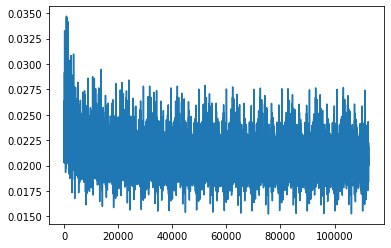

Least cost occurs at iteration:
75538
Least cost occurs at epoch: 
7.3767578125
min loss:
0.015237163999449552

Epoch no: 11 in 20 Time: Sun Dec 15 03:07:28 2019Sun Dec 15 03:08:14 2019


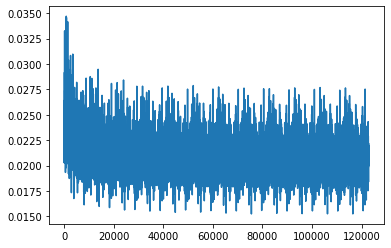

Least cost occurs at iteration:
75538
Least cost occurs at epoch: 
7.3767578125
min loss:
0.015237163999449552

Epoch no: 12 in 20 Time: Sun Dec 15 03:08:14 2019Sun Dec 15 03:09:00 2019


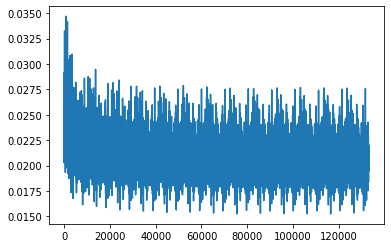

Least cost occurs at iteration:
75538
Least cost occurs at epoch: 
7.3767578125
min loss:
0.015237163999449552

Epoch no: 13 in 20 Time: Sun Dec 15 03:09:00 2019Sun Dec 15 03:09:46 2019


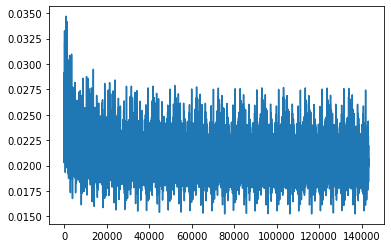

Least cost occurs at iteration:
75538
Least cost occurs at epoch: 
7.3767578125
min loss:
0.015237163999449552

Epoch no: 14 in 20 Time: Sun Dec 15 03:09:46 2019Sun Dec 15 03:10:32 2019


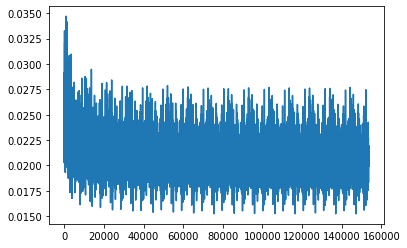

Least cost occurs at iteration:
147218
Least cost occurs at epoch: 
14.3767578125
min loss:
0.015227433739431884

Epoch no: 15 in 20 Time: Sun Dec 15 03:10:32 2019Sun Dec 15 03:11:17 2019


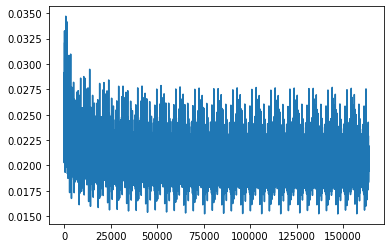

Least cost occurs at iteration:
147218
Least cost occurs at epoch: 
14.3767578125
min loss:
0.015227433739431884

Epoch no: 16 in 20 Time: Sun Dec 15 03:11:18 2019Sun Dec 15 03:12:02 2019


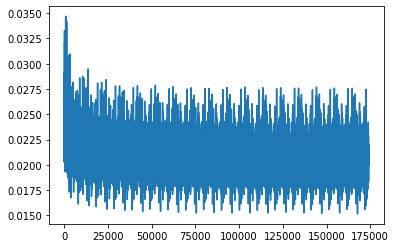

Least cost occurs at iteration:
167698
Least cost occurs at epoch: 
16.3767578125
min loss:
0.015152986282378164

Epoch no: 17 in 20 Time: Sun Dec 15 03:12:02 2019Sun Dec 15 03:12:47 2019


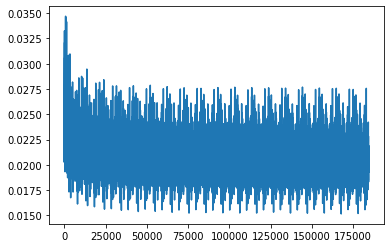

Least cost occurs at iteration:
167698
Least cost occurs at epoch: 
16.3767578125
min loss:
0.015152986282378164

Epoch no: 18 in 20 Time: Sun Dec 15 03:12:48 2019Sun Dec 15 03:13:33 2019


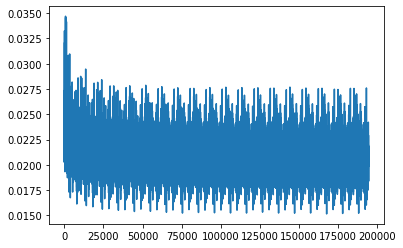

Least cost occurs at iteration:
167698
Least cost occurs at epoch: 
16.3767578125
min loss:
0.015152986282378164

Epoch no: 19 in 20 Time: Sun Dec 15 03:13:33 2019Sun Dec 15 03:14:18 2019


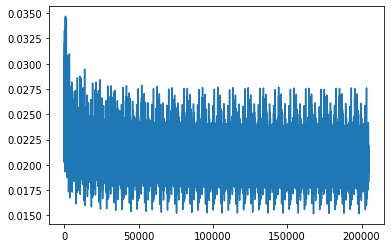

Least cost occurs at iteration:
167698
Least cost occurs at epoch: 
16.3767578125
min loss:
0.015152986282378164


In [0]:
W00= nn(81,20,1,0.3,0.05,0.01,0.01,Loss = True)

# **Experimenting with different parameters**

In [0]:
from google.colab import files

W1 = nn(64,20,1,0.3,0.05,0.01,0.01)

W2= nn(100,20,1,0.3,0.05,0.01,0.01)

W3 =  nn(25,20,1,0.3,0.05,0.01,0.01)

W4 = nn(64,20,1,0.3,0.05,0.01,0.001)

W5= nn(64,20,1,0.3,0.05,0.01,0.1)

Hidden layer number:64 Learning rate:0.3 Epoch number:20 Batch size:1


Training started.   Time: Sun Dec 15 03:39:14 2019

Epoch no: 0 in 20 Time: Sun Dec 15 03:39:14 2019
Epoch no: 1 in 20 Time: Sun Dec 15 03:39:43 2019
Epoch no: 2 in 20 Time: Sun Dec 15 03:40:13 2019
Epoch no: 3 in 20 Time: Sun Dec 15 03:40:43 2019
Epoch no: 4 in 20 Time: Sun Dec 15 03:41:12 2019
Epoch no: 5 in 20 Time: Sun Dec 15 03:41:41 2019
Epoch no: 6 in 20 Time: Sun Dec 15 03:42:10 2019
Epoch no: 7 in 20 Time: Sun Dec 15 03:42:40 2019
Epoch no: 8 in 20 Time: Sun Dec 15 03:43:09 2019
Epoch no: 9 in 20 Time: Sun Dec 15 03:43:38 2019
Epoch no: 10 in 20 Time: Sun Dec 15 03:44:08 2019
Epoch no: 11 in 20 Time: Sun Dec 15 03:44:37 2019
Epoch no: 12 in 20 Time: Sun Dec 15 03:45:06 2019
Epoch no: 13 in 20 Time: Sun Dec 15 03:45:36 2019
Epoch no: 14 in 20 Time: Sun Dec 15 03:46:05 2019
Epoch no: 15 in 20 Time: Sun Dec 15 03:46:34 2019
Epoch no: 16 in 20 Time: Sun Dec 15 03:47:04 2019
Epoch no: 17 in 20 Time: Sun Dec 15 

In [0]:
W00= nn(100,50,1,0.3,0.05,0.01,0.01)

Hidden layer number:100 Learning rate:0.3 Epoch number:50 Batch size:1


Training started.   Time: Sun Dec 15 09:50:52 2019

Epoch no: 0 in 50 Time: Sun Dec 15 09:50:52 2019
Epoch no: 1 in 50 Time: Sun Dec 15 09:51:22 2019
Epoch no: 2 in 50 Time: Sun Dec 15 09:51:53 2019
Epoch no: 3 in 50 Time: Sun Dec 15 09:52:24 2019
Epoch no: 4 in 50 Time: Sun Dec 15 09:52:55 2019
Epoch no: 5 in 50 Time: Sun Dec 15 09:53:26 2019
Epoch no: 6 in 50 Time: Sun Dec 15 09:53:57 2019
Epoch no: 7 in 50 Time: Sun Dec 15 09:54:29 2019
Epoch no: 8 in 50 Time: Sun Dec 15 09:55:00 2019
Epoch no: 9 in 50 Time: Sun Dec 15 09:55:32 2019
Epoch no: 10 in 50 Time: Sun Dec 15 09:56:03 2019
Epoch no: 11 in 50 Time: Sun Dec 15 09:56:34 2019
Epoch no: 12 in 50 Time: Sun Dec 15 09:57:06 2019
Epoch no: 13 in 50 Time: Sun Dec 15 09:57:37 2019
Epoch no: 14 in 50 Time: Sun Dec 15 09:58:08 2019
Epoch no: 15 in 50 Time: Sun Dec 15 09:58:40 2019
Epoch no: 16 in 50 Time: Sun Dec 15 09:59:12 2019
Epoch no: 17 in 50 Time: Sun Dec 15

In [0]:
Wbb= nn(64,10,1,0.3,0.05,0.01,0.0005)

Hidden layer number:64 Learning rate:0.3 Epoch number:10 Batch size:1


Training started.   Time: Sun Dec 15 17:10:22 2019

Epoch no: 0 in 10 Time: Sun Dec 15 17:10:22 2019
Epoch no: 1 in 10 Time: Sun Dec 15 17:11:00 2019
Epoch no: 2 in 10 Time: Sun Dec 15 17:11:38 2019
Epoch no: 3 in 10 Time: Sun Dec 15 17:12:15 2019
Epoch no: 4 in 10 Time: Sun Dec 15 17:12:53 2019
Epoch no: 5 in 10 Time: Sun Dec 15 17:13:31 2019
Epoch no: 6 in 10 Time: Sun Dec 15 17:14:09 2019
Epoch no: 7 in 10 Time: Sun Dec 15 17:14:46 2019
Epoch no: 8 in 10 Time: Sun Dec 15 17:15:24 2019
Epoch no: 9 in 10 Time: Sun Dec 15 17:16:01 2019

# **Saving weights to my local computer**

In [0]:
np.savetxt("W00.txt",np.array(W00))
np.savetxt("W1.txt",np.array(W1))
np.savetxt("W2.txt",np.array(W2))
np.savetxt("W3.txt",np.array(W3))
np.savetxt("W4.txt",np.array(W4))
np.savetxt("W5.txt",np.array(W5))

In [0]:
files.download("W00.txt")
files.download("W1.txt")
files.download("W2.txt")
files.download("W3.txt")
files.download("W4.txt")
files.download("W5.txt")

In [0]:
W00 = np.loadtxt("W00.txt").T[:-1].T
W1 = np.loadtxt("W1.txt").T[:-1].T
W2 = np.loadtxt("W2.txt").T[:-1].T
W3 = np.loadtxt("W3.txt").T[:-1].T
W4 = np.loadtxt("W4.txt").T[:-1].T
W5 = np.loadtxt("W5.txt").T[:-1].T

print(W1.shape)
print(W2.shape)
print(W3.shape)
print(W4.shape)
print(W5.shape)

(256, 64)
(256, 100)
(256, 25)
(256, 64)
(256, 64)


# **Real images *vs* Autoencoder outputs**

(256, 64)
real


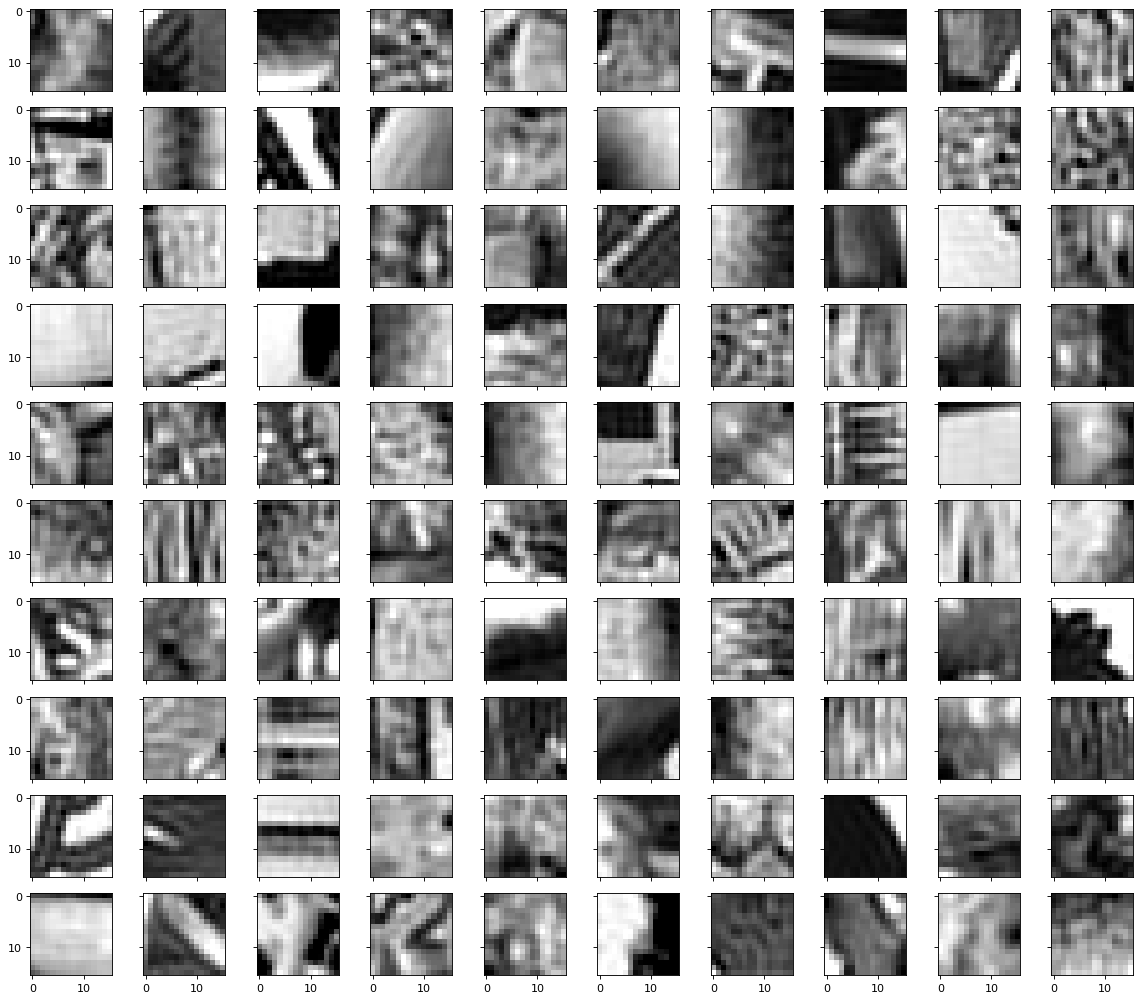

outputs


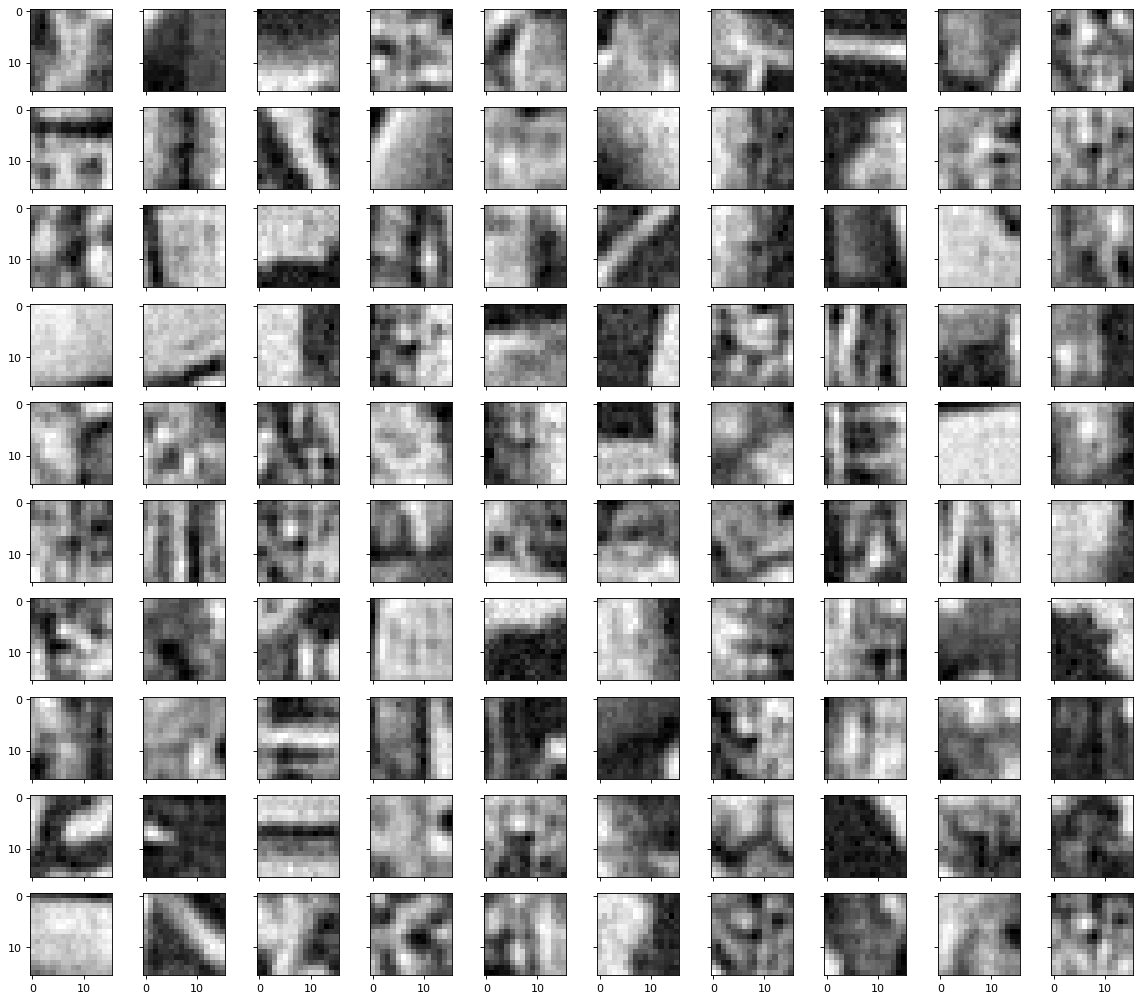

In [0]:
(aeCost(Wbb,0.004,0.0005,0.0005,0.01,QualityCheck=True))

W00---------------------------------------------------
(256, 100)
real


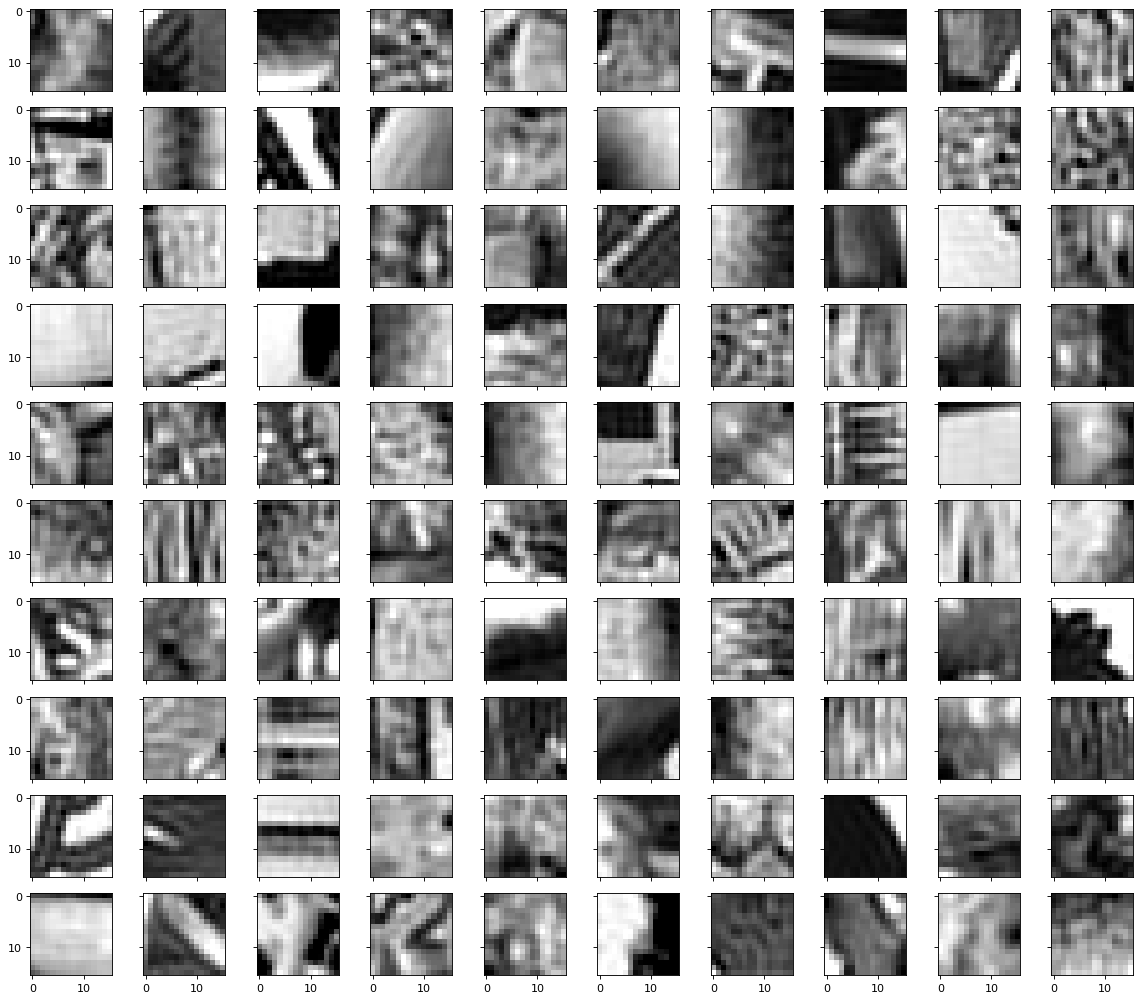

outputs


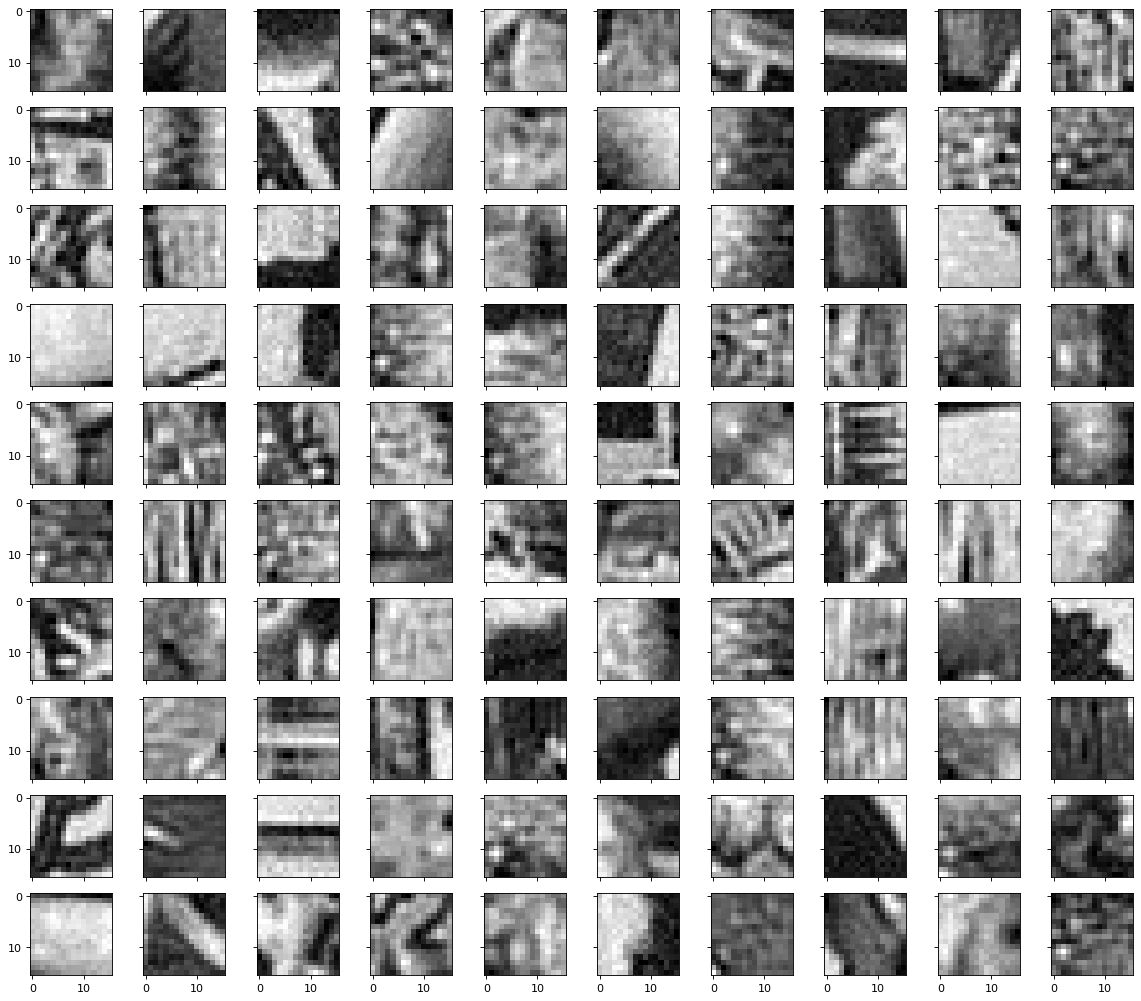

W1---------------------------------------------------
(256, 64)
real


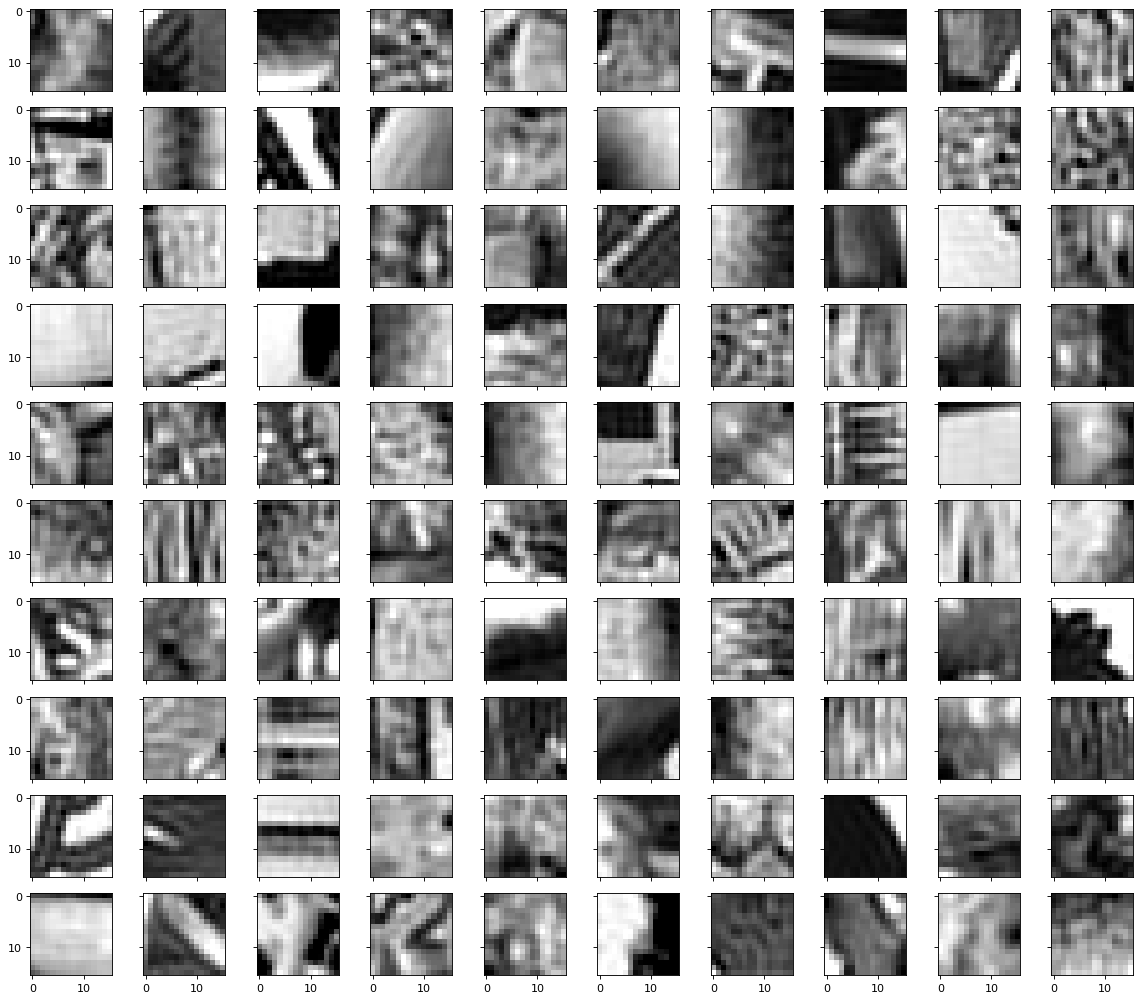

outputs


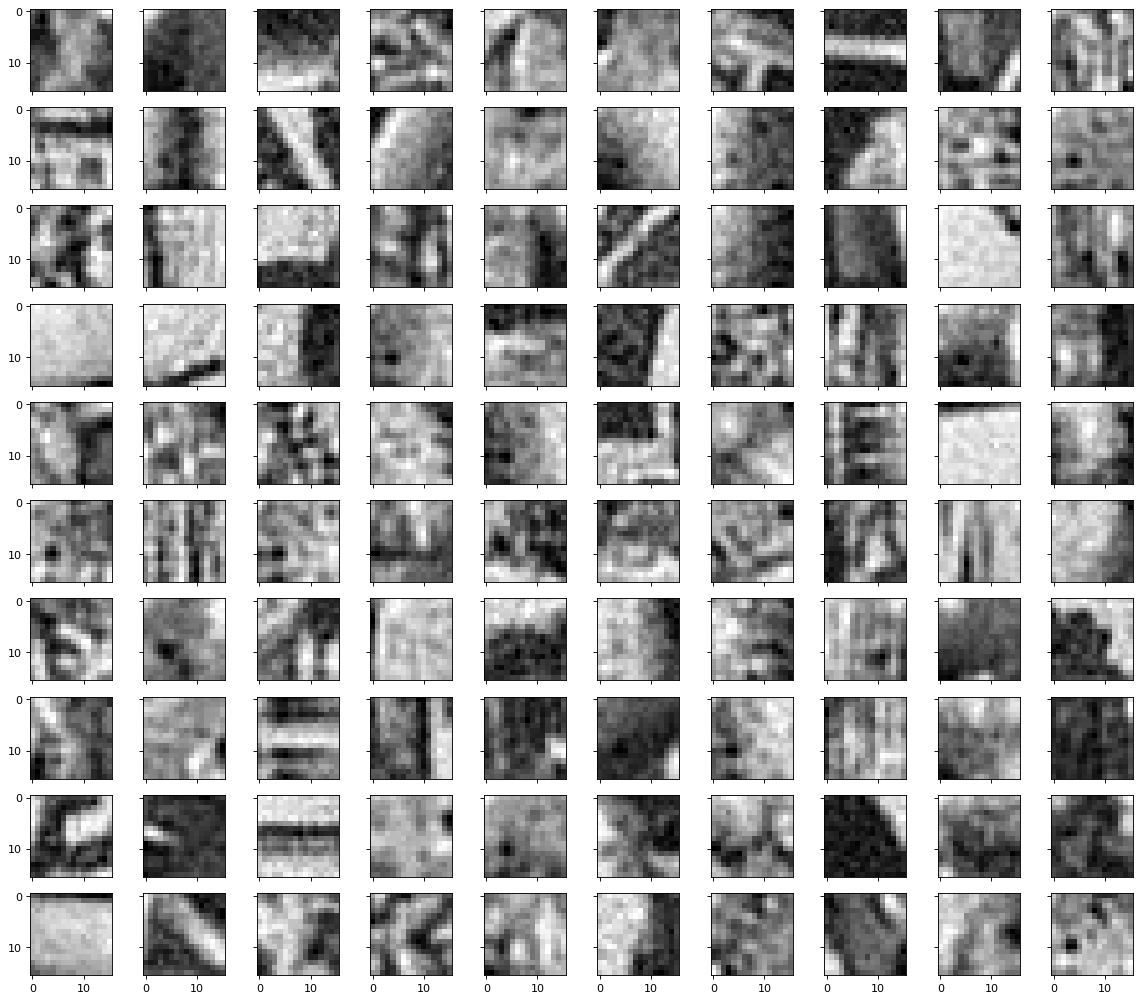

W2---------------------------------------------------
(256, 100)
real


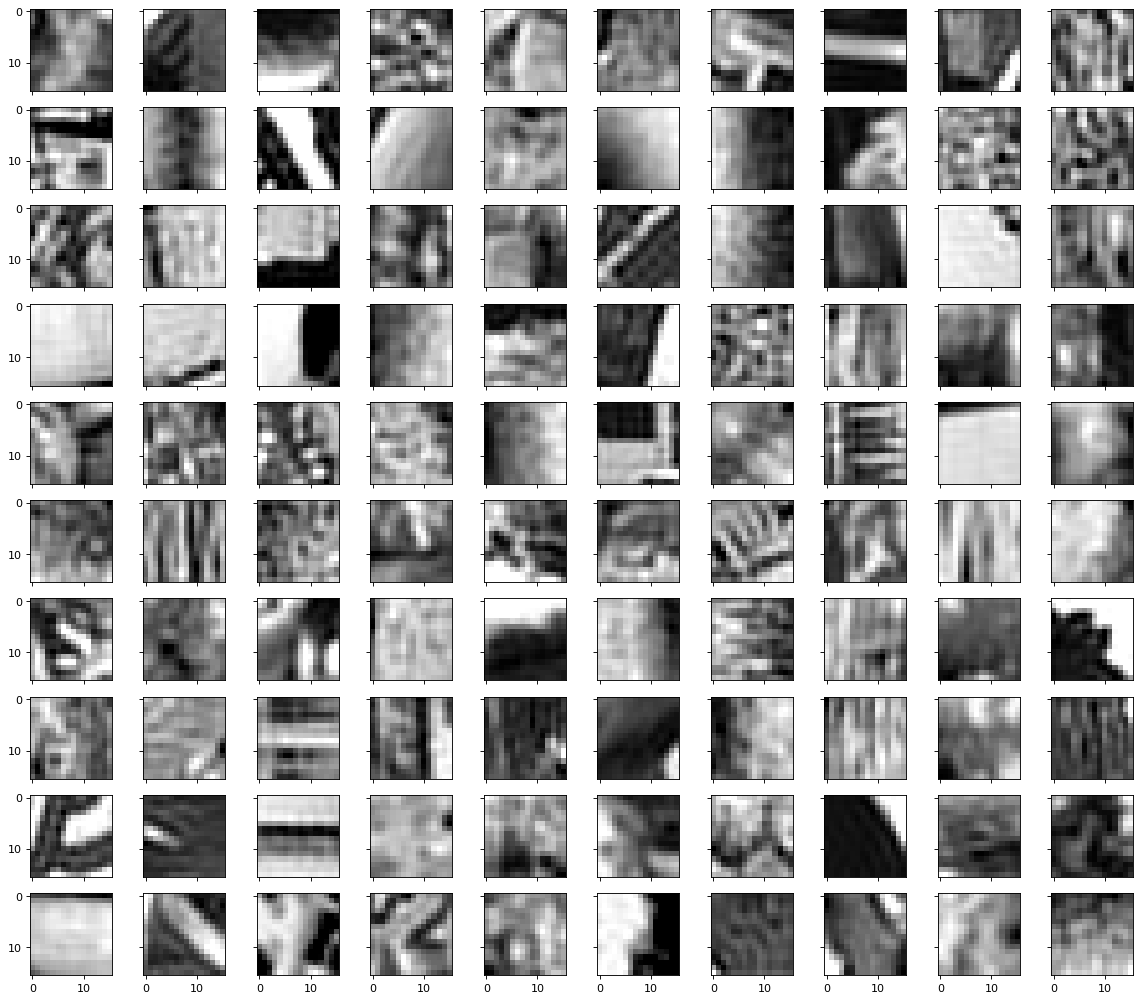

outputs


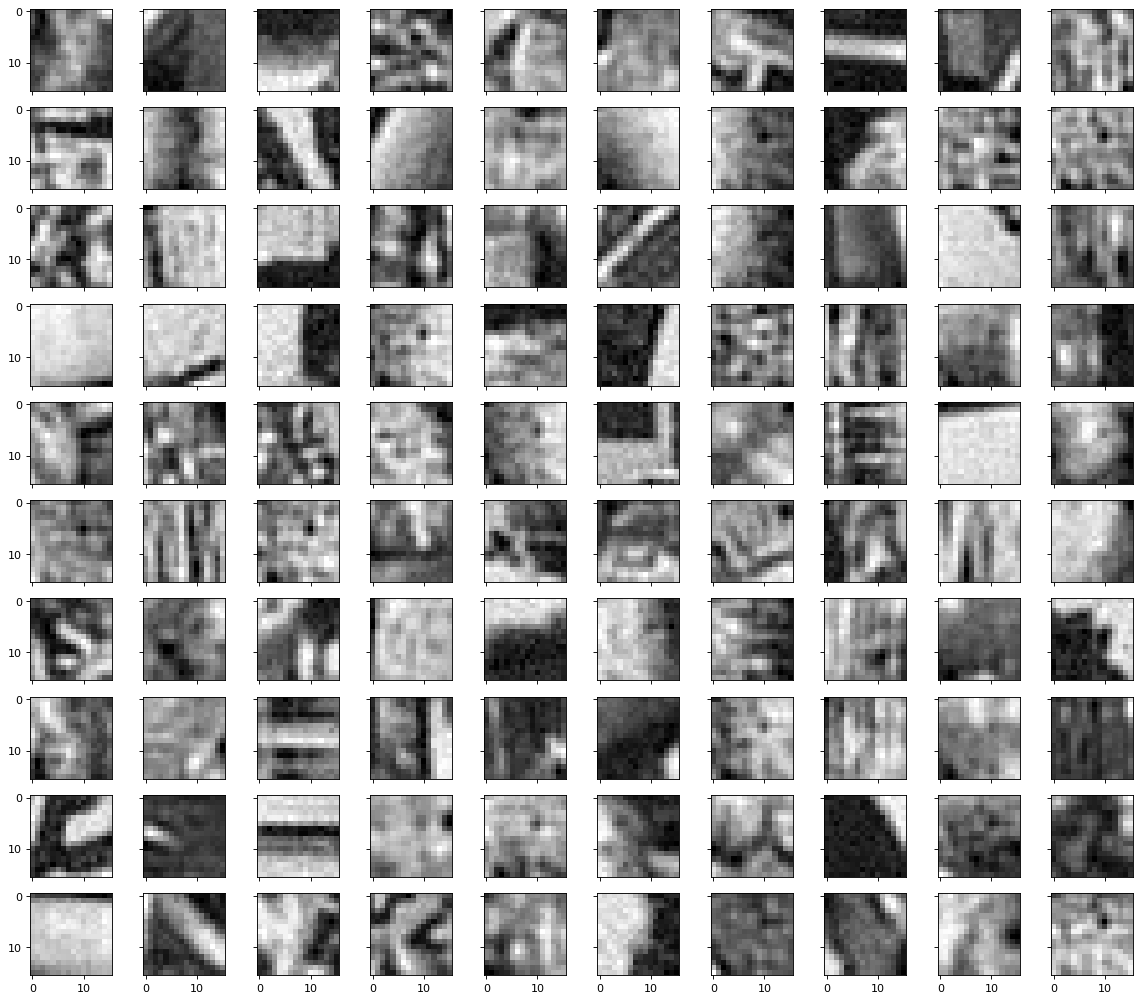

W3---------------------------------------------------
(256, 25)
real


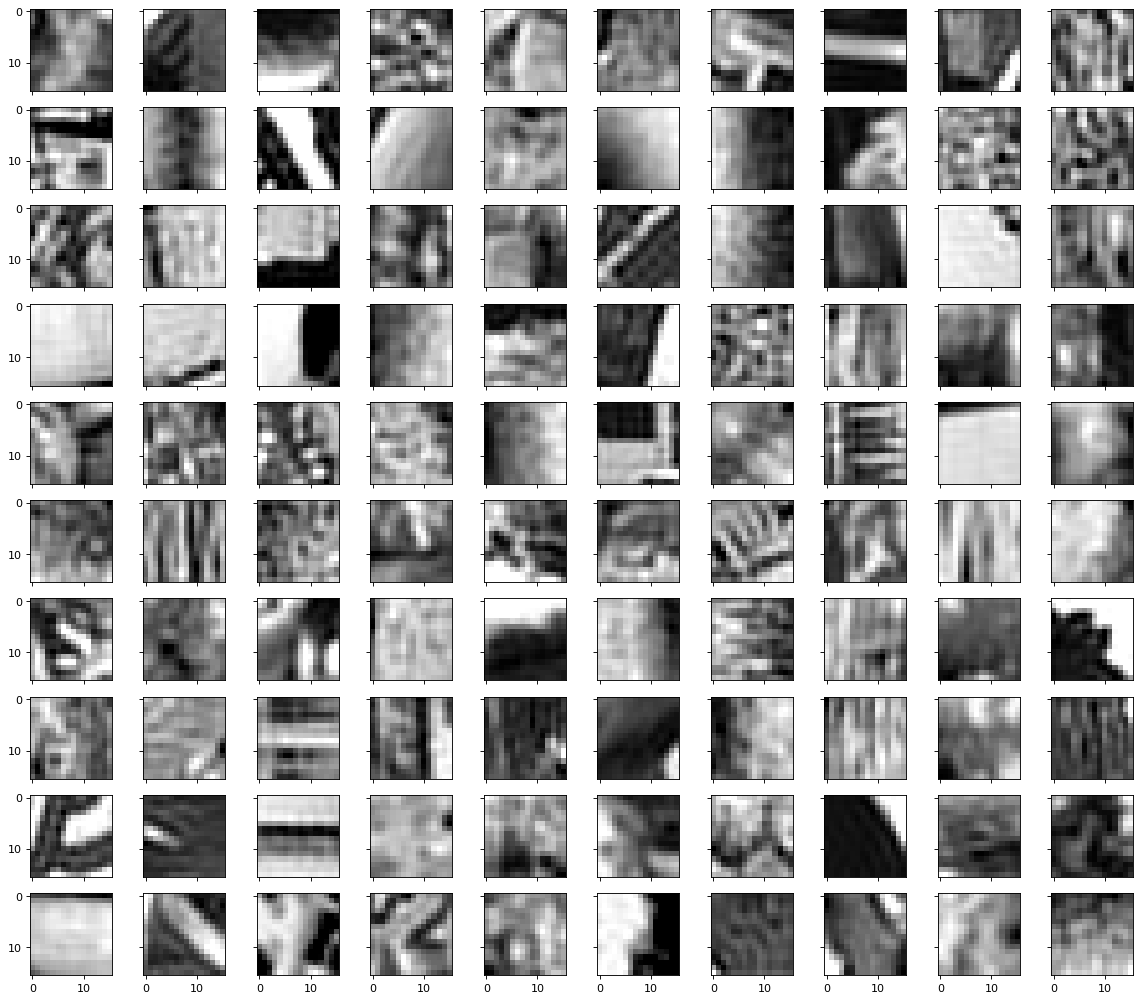

outputs


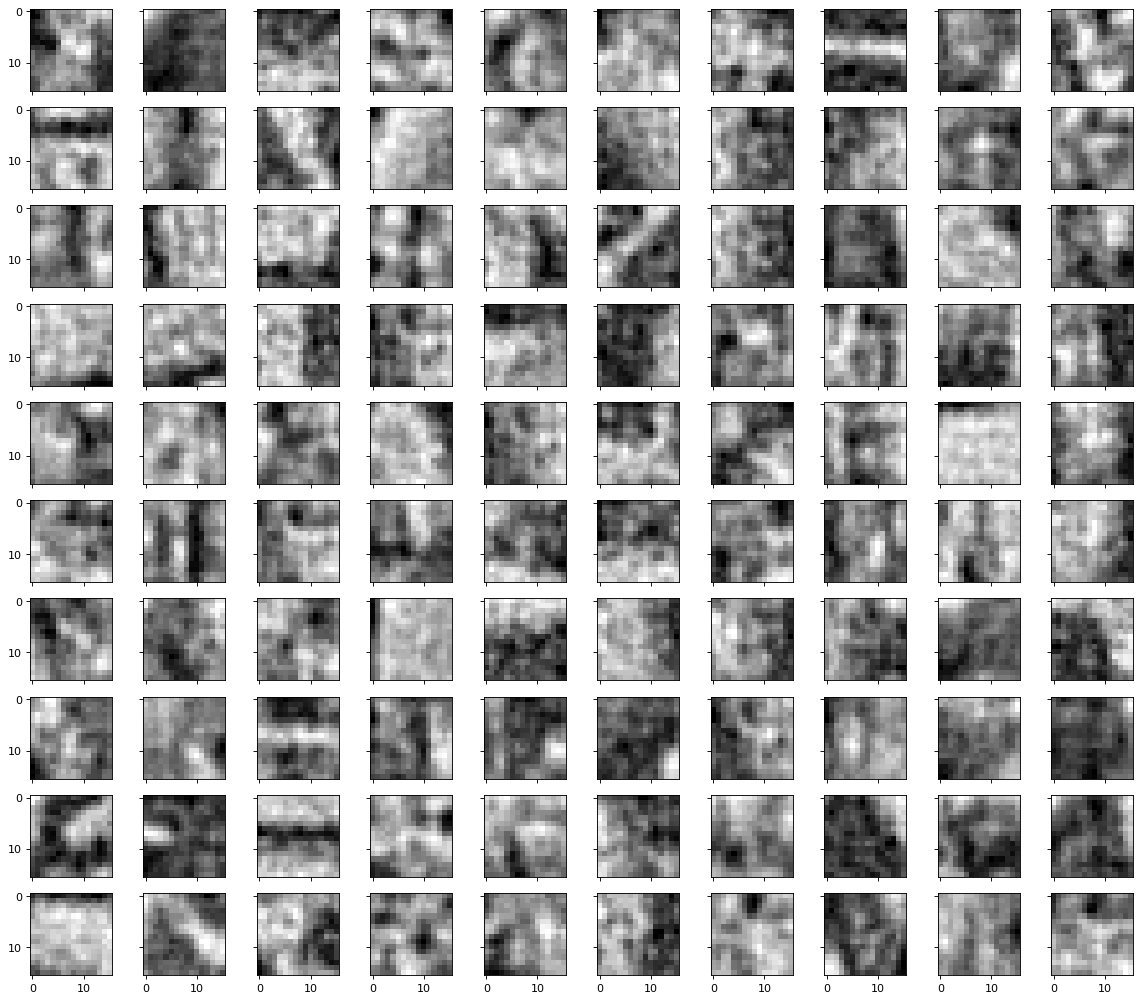

W4---------------------------------------------------
(256, 64)
real


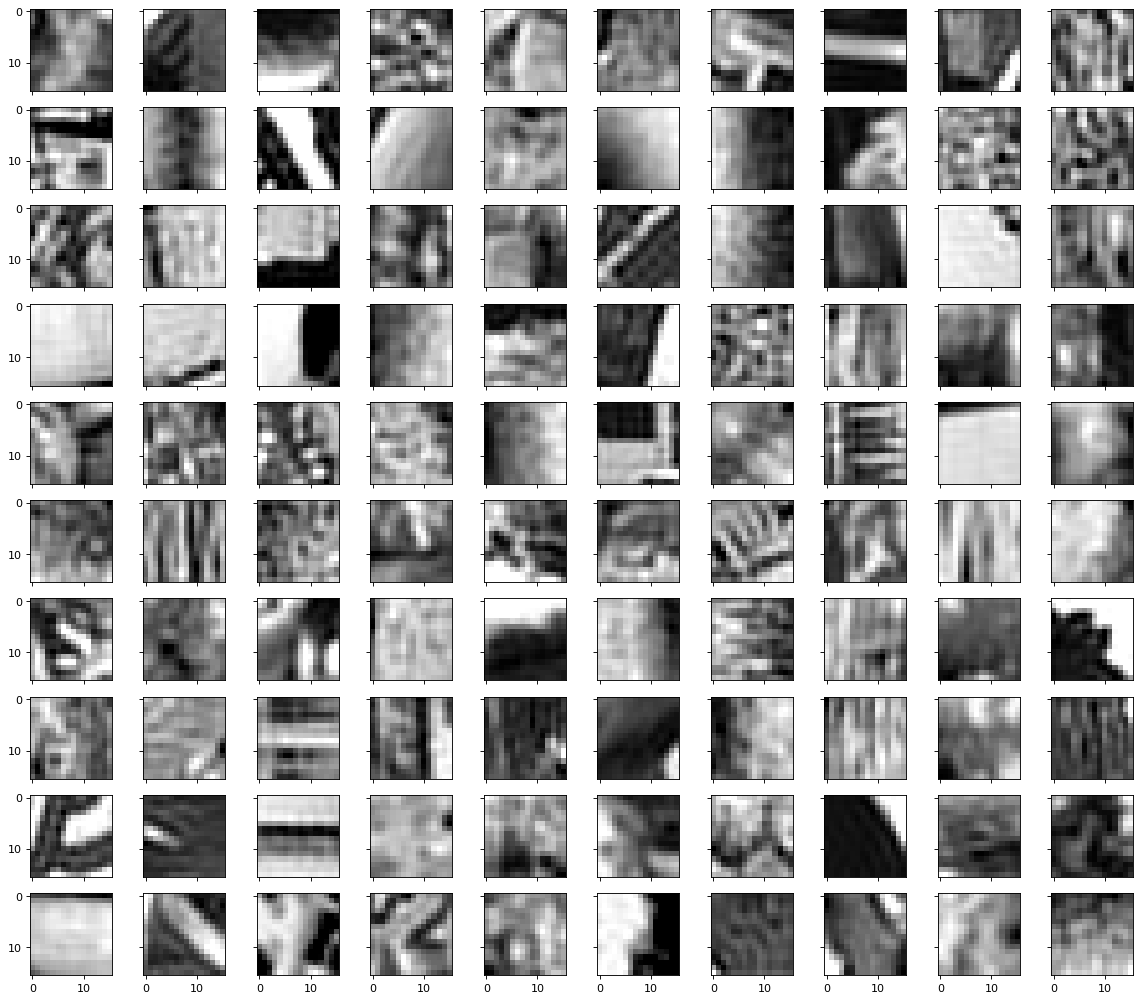

outputs


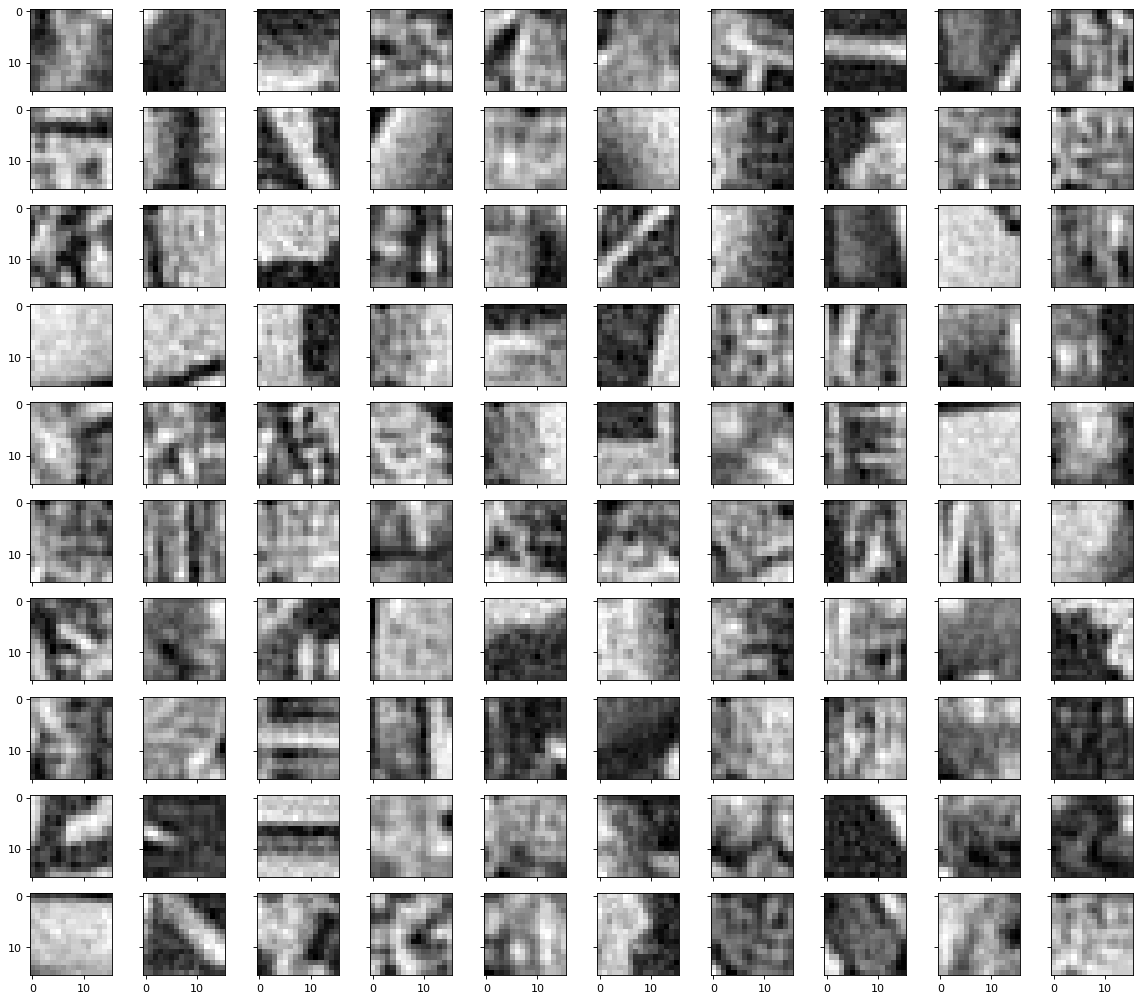

W5---------------------------------------------------
(256, 64)
real


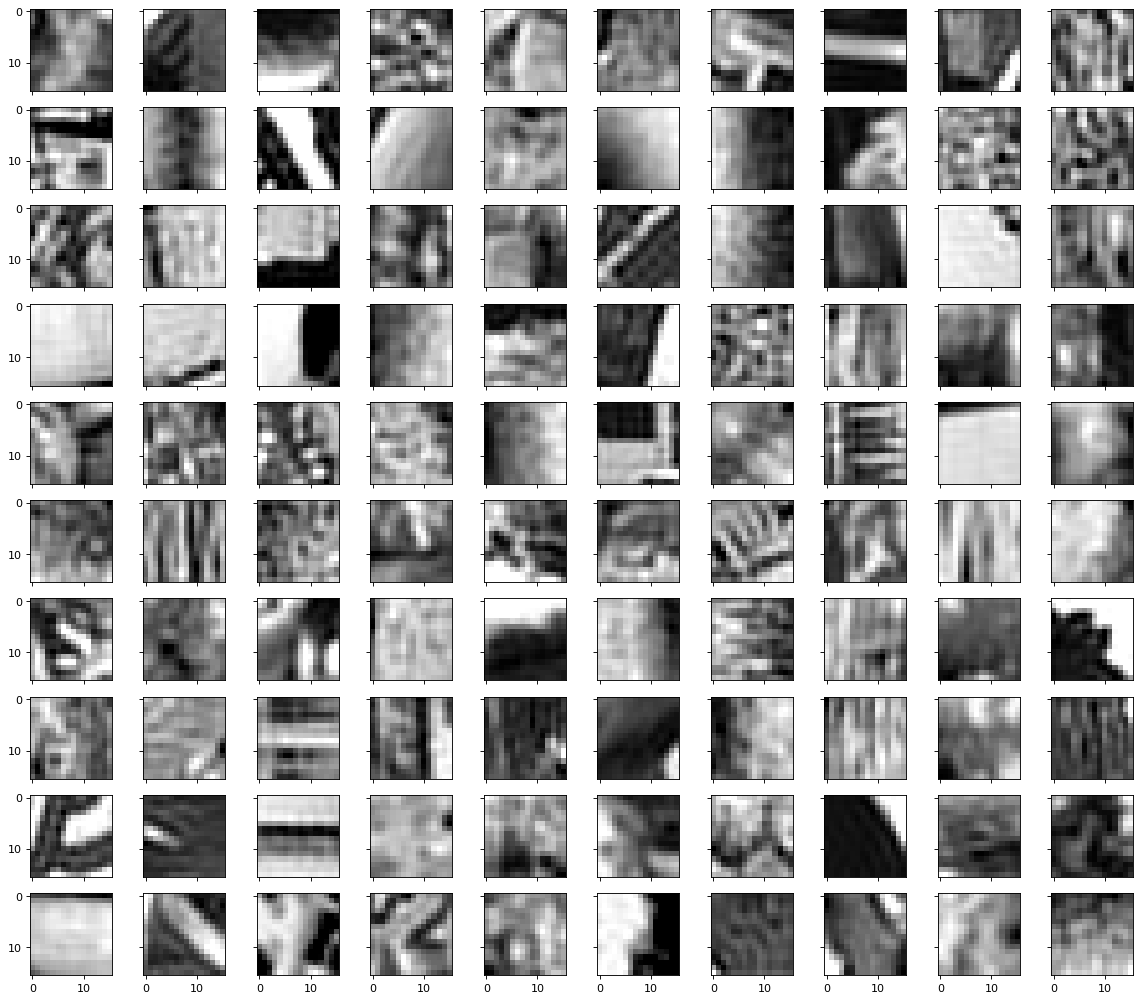

outputs


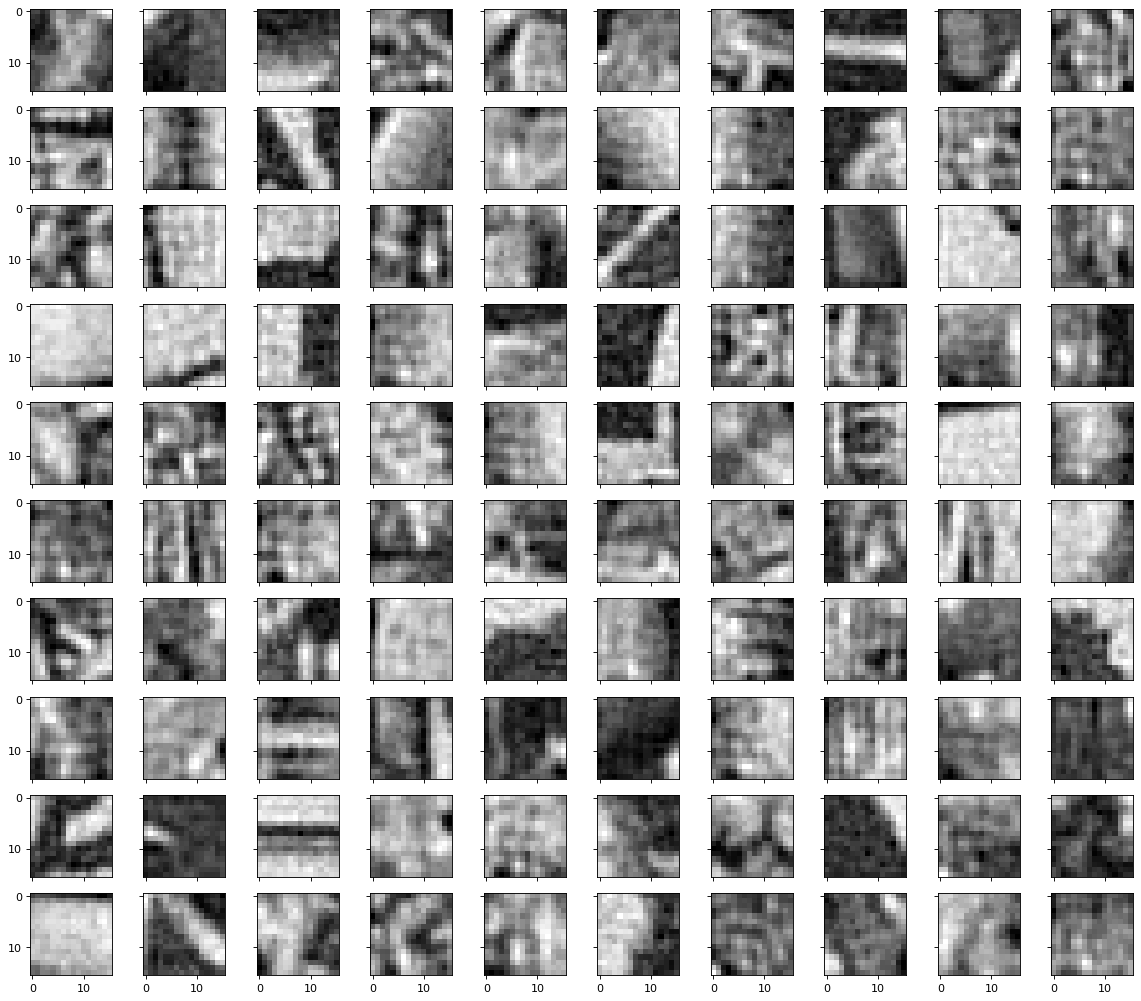

In [0]:
print("W00---------------------------------------------------")
(aeCost(W00,0.004,0.0005,0.0005,0.01,QualityCheck=True))
print("W1---------------------------------------------------")
(aeCost(W1,0.004,0.0005,0.0005,0.01,QualityCheck=True))
print("W2---------------------------------------------------")
(aeCost(W2,0.004,0.0005,0.0005,0.01,QualityCheck=True))
print("W3---------------------------------------------------")
(aeCost(W3,0.004,0.0005,0.0005,0.01,QualityCheck=True))
print("W4---------------------------------------------------")
(aeCost(W4,0.004,0.0005,0.0005,0.001,QualityCheck=True))
print("W5---------------------------------------------------")
(aeCost(W5,0.004,0.0005,0.0005,0.1,QualityCheck=True))

# (W,learningrate,rho,beta,lamda,QualityCheck = False)
# W1 = nn(64,20,1,0.3,0.05,0.01,0.01)

# **Visualization of weights**

-------------------------------------
(256, 100)
weights
(100, 256)


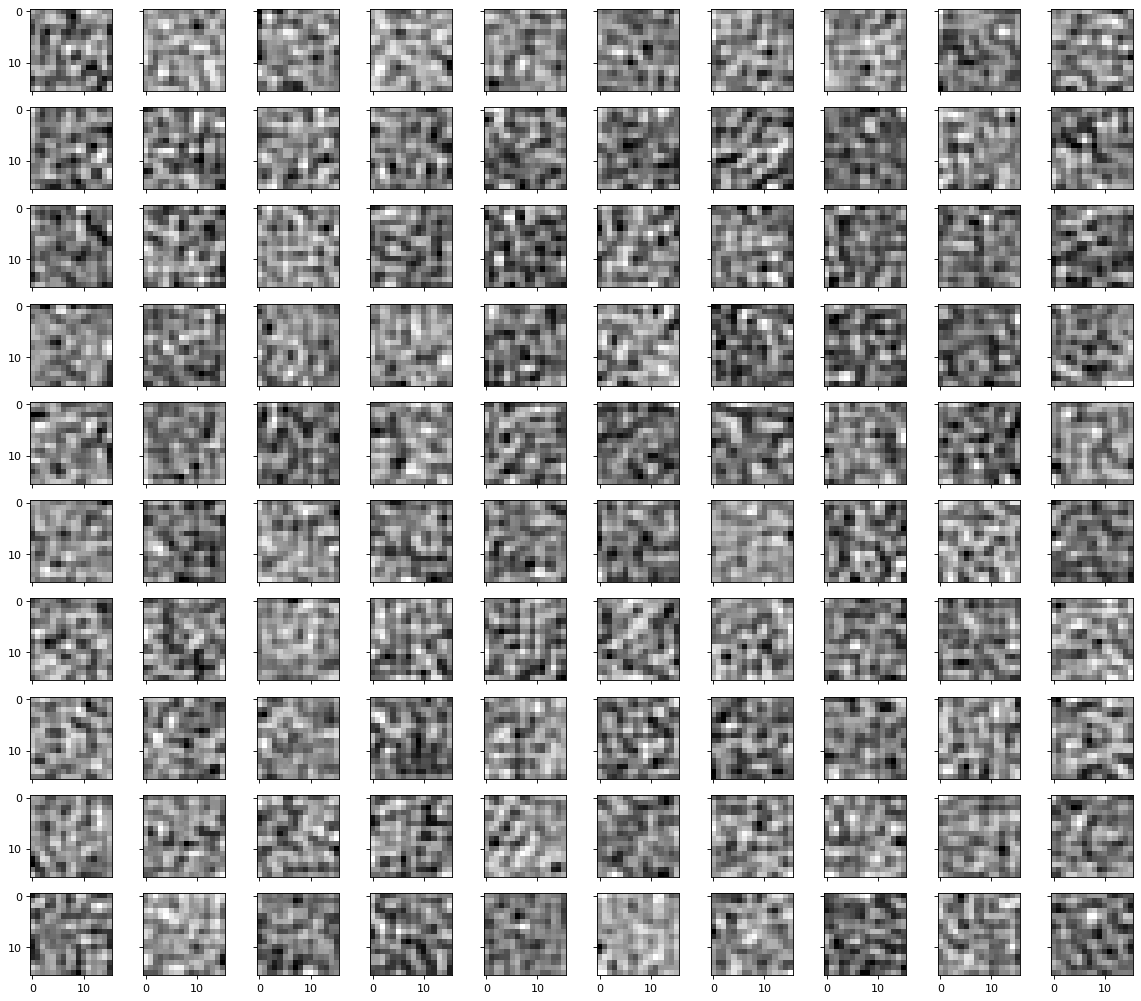

-------------------------------------
-------------------------------------
(256, 64)
weights
(64, 256)


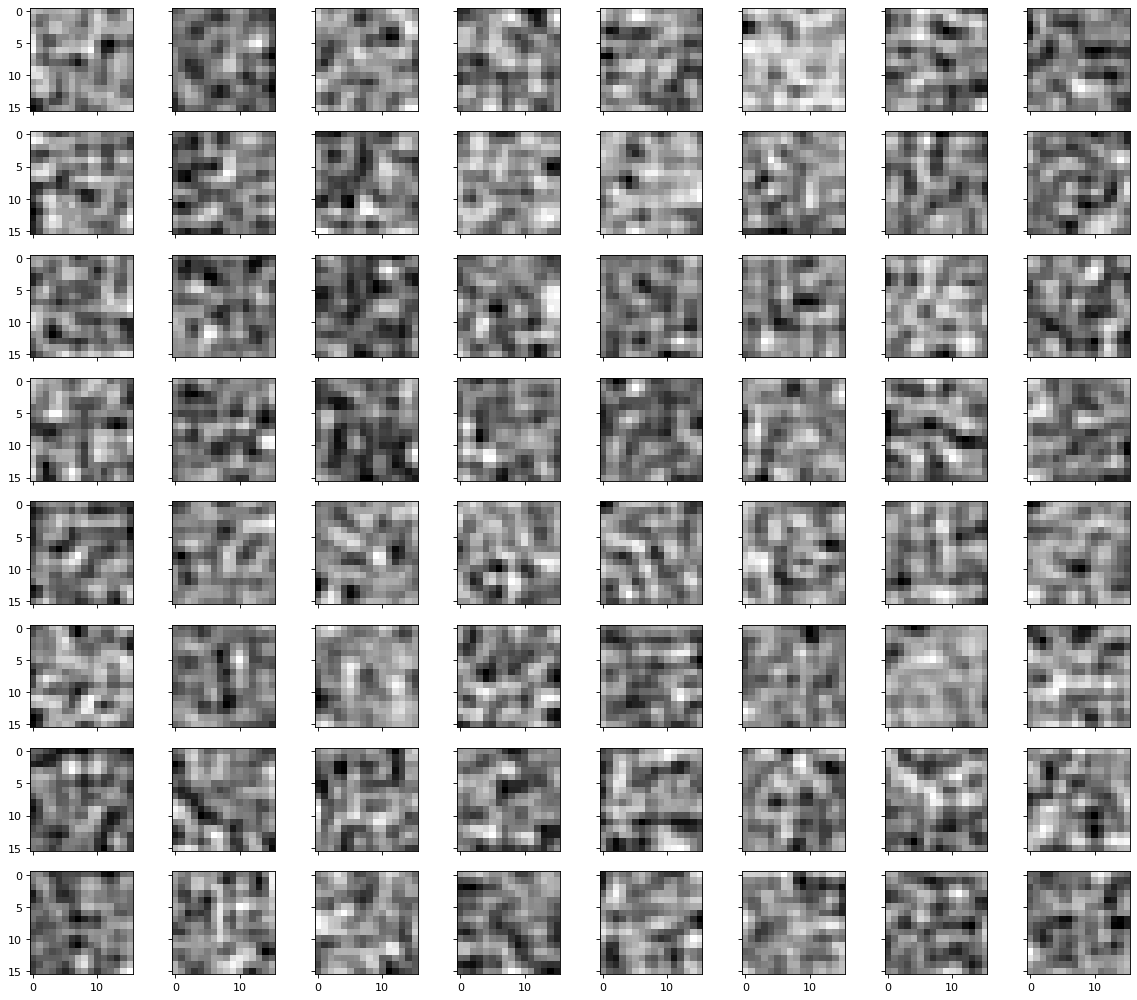

-------------------------------------
-------------------------------------
(256, 100)
weights
(100, 256)


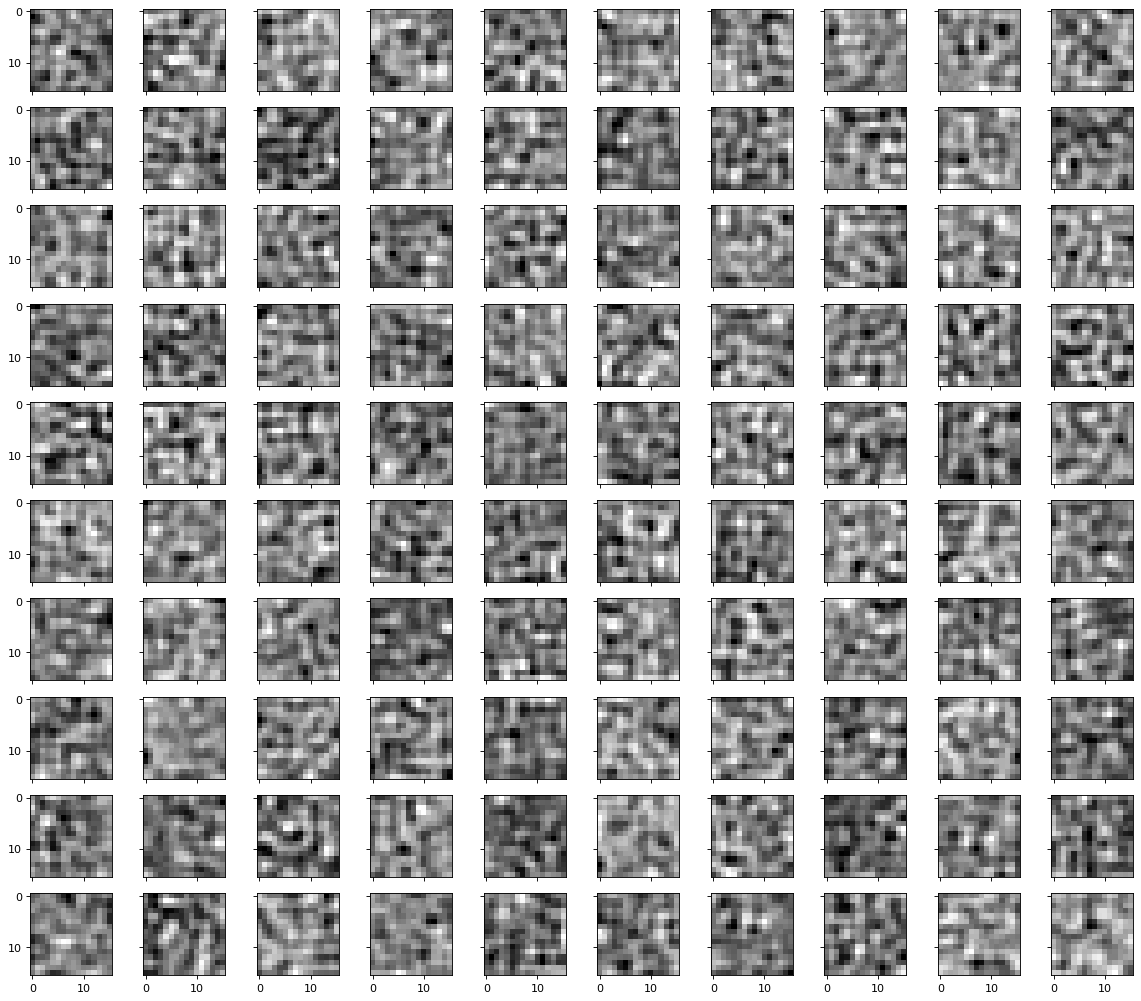

-------------------------------------
-------------------------------------
(256, 25)
weights
(25, 256)


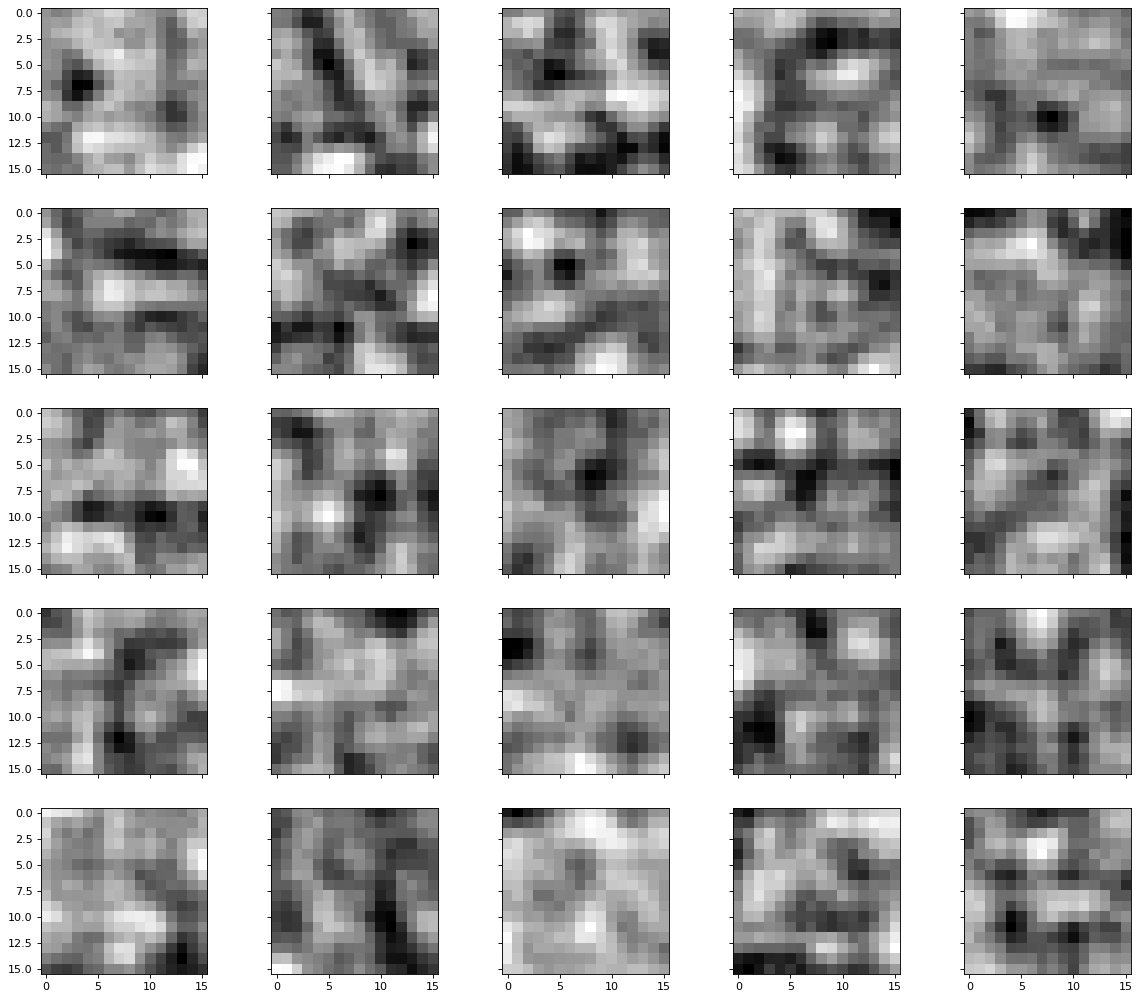

-------------------------------------
-------------------------------------
(256, 64)
weights
(64, 256)


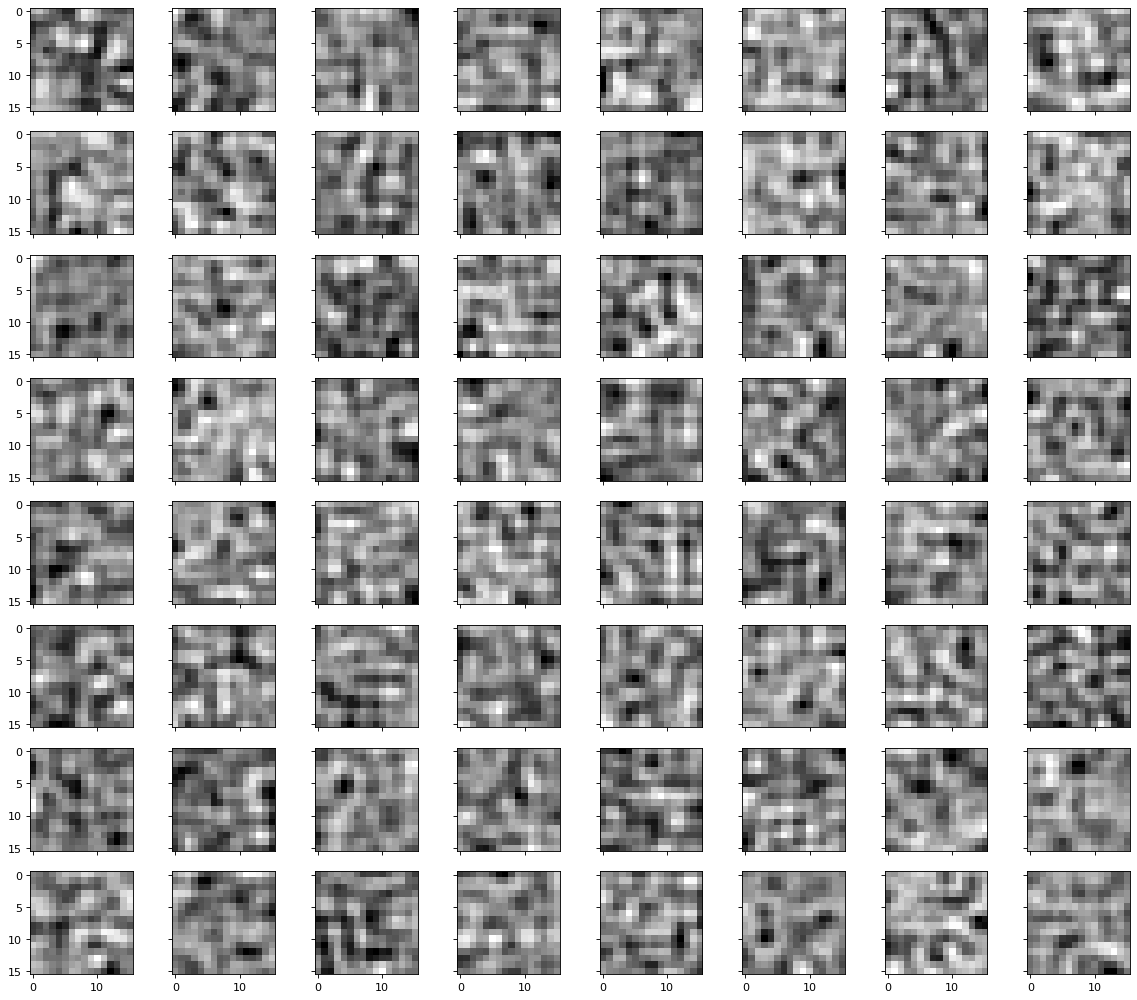

-------------------------------------
-------------------------------------
(256, 64)
weights
(64, 256)


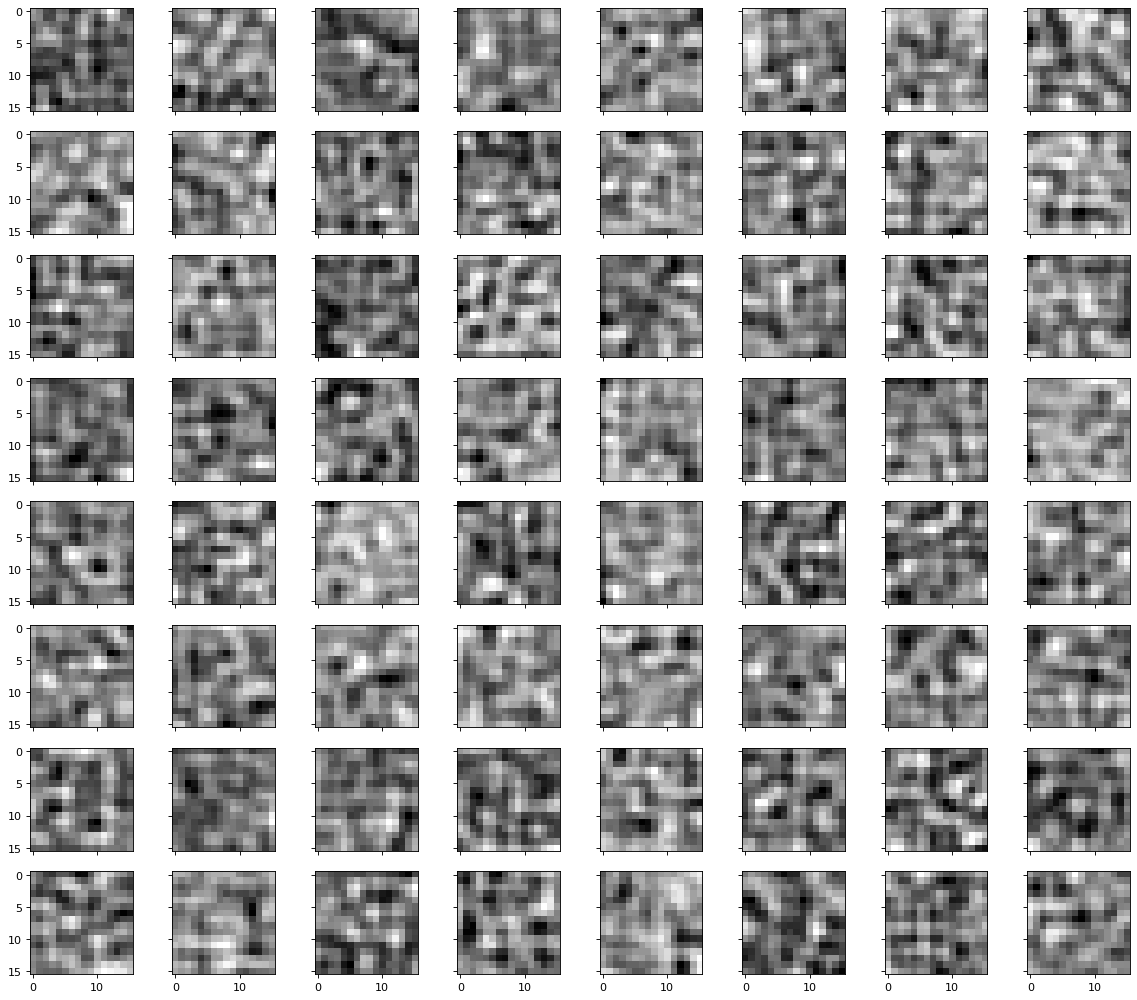

-------------------------------------


In [0]:
a = [W00, W1,W2,W3,W4,W5]
for W in a:
    W = np.array(W)
    print("-------------------------------------")
    print(W.shape)
    drawWeights(W)
    print("-------------------------------------")